# Import and settings

In [9]:
import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々

import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm

import logging
import logzero
from logzero import logger


# examination settings
batch_size = 128
test_batch_size = batch_size * 4
momentum = 0.9
seed = 2017
num_workers = 2
use_gpu = False

# set seed for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)

# logger setting
LOG_FORMAT = '[%(asctime)s %(levelname)s] %(message)s'
logzero.loglevel(logging.INFO)
logzero.formatter(logging.Formatter(LOG_FORMAT))

# Prepare data

In [37]:
train_dataset = datasets.MNIST('./data/MNIST/train/', download=True, train=True)
test_dataset = datasets.MNIST('./data/MNIST/test/', download=True, train=False)

train_data = train_dataset.train_data.numpy()
test_data = test_dataset.test_data.numpy()
train_labels = train_dataset.train_labels.numpy()
test_labels = test_dataset.test_labels.numpy()

In [38]:
print(len(train_labels), len(test_labels))

60000 10000


## Change the ratio train/test

In [39]:
n_train = 1000
n_val = 1000
n_test = 10000
n_unlabeled = 58000

X_train = np.empty(shape=(0, 28, 28))
y_train = np.empty(shape=(0,))
X_val = np.empty(shape=(0, 28, 28))
y_val = np.empty(shape=(0,))
X_test = np.empty(shape=(0, 28, 28))
y_test = np.empty(shape=(0,))

for i in range(10):
    idx_train = np.argwhere(train_labels == i)[:(n_train//10)].squeeze()
    idx_val = np.argwhere(train_labels == i)[(n_train//10):((n_train+n_val)//10)].squeeze()
    idx_test = np.argwhere(train_labels == i)[((n_train+n_val)//10):].squeeze()
    
    X_train = np.concatenate([X_train, train_data[idx_train]], axis=0)
    y_train = np.concatenate([y_train, train_labels[idx_train]], axis=0)
    X_val = np.concatenate([X_val, train_data[idx_val]], axis=0)
    y_val = np.concatenate([y_val, train_labels[idx_val]], axis=0)
    X_test = np.concatenate([X_test, train_data[idx_test]], axis=0)
    y_test = np.concatenate([y_test, train_labels[idx_test]], axis=0)
    
X_test = np.concatenate([X_test, test_data], axis=0)
y_test = np.concatenate([y_test, test_labels], axis=0)

# treat as image
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)

# one-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_val = lb.transform(y_val)
y_test = lb.transform(y_test)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1000, 28, 28, 1) (1000, 10) (1000, 28, 28, 1) (1000, 10) (68000, 28, 28, 1) (68000, 10)


## Prepare Pseudo Label

testデータをtest/unlabeledに分ける。
比率は10000:58000とする。（元々のMNISTの提供時点でのtest splitを用いる）
その後、unlabeledデータの中で更にhard/easy sampleを分ける。実際のシチュエーションではunlabeledなので正解がわからない。そのため、クラス間で最大のsoftmax値の値が閾値より低ければ「hard sample」とみなす。しきい値は大体0.99あたりで良さそう。

unlabeledデータを学習終了時に評価するが、この際、pseudo labelとして学習に使った/使っていない　データを区別せずに評価する。理由としてはhard sampleとされたデータのunlabeled accuracyは明らかにバイアスがかかってしまうため。（まあ、低い精度になるだろう）

In [40]:
y_pseudo = np.load('./save/pseudo_label_supervised.npy')

idx = np.max(y_pseudo[:n_unlabeled], axis=-1) > 0.99

X_unlabeled = X_test[:n_unlabeled]
y_unlabeled = y_test[:n_unlabeled]
X_pseudo = X_unlabeled[idx]
y_pseudo = y_pseudo[:n_unlabeled][idx]
X_test = X_test[n_unlabeled:]
y_test = y_test[n_unlabeled:]

print(
    X_unlabeled.shape, y_unlabeled.shape,
    X_pseudo.shape, y_pseudo.shape,
    X_test.shape, y_test.shape
)

(58000, 28, 28, 1) (58000, 10) (34163, 28, 28, 1) (34163, 10) (10000, 28, 28, 1) (10000, 10)


# Define a network

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), 2))
        x = F.adaptive_max_pool2d(x, output_size=1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x)
        return x

# Define Dataset, DataLoader

In [18]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        img = self.X[index]
        img = self.transform(img)
        target = torch.Tensor(self.y[index].astype(float))
        return img, target
    
    def __len__(self):
        return len(self.X)


class MNISTDatasetForPseudoLabeling(torch.utils.data.Dataset):
    def __init__(self, X_train, y_train, X_dash, y_dash, ratio_pl, hard, transform):
        self.X_train = X_train
        self.y_train = y_train
        self.X_dash = X_dash
        self.y_dash = y_dash
        self.ratio_pl = ratio_pl
        self.hard = hard
        self.transform = transform
        
    def __getitem__(self, index):
        if index < len(self.X_train):
            img = self.X_train[index]
            target = torch.Tensor(self.y_train[index].astype(float))
        else:
            index = np.random.randint(0, len(self.X_dash))
            img = self.X_dash[index]
            if self.hard:
                hard_label = int(np.argmax(self.y_dash[index]))
                zeros = np.zeros_like(self.y_dash[index])
                zeros[hard_label] = 1.0
                target = torch.Tensor(zeros)
            else:
                target = torch.Tensor(self.y_dash[index].astype(float))
        
        img = self.transform(img)
        return img, target
    
    def __len__(self):
        return int(len(self.X_train) * (1 + ratio_pl))

# Define TrainingTracker

In [19]:
class TrainingTracker(object):
    def __init__(self):
        self.epoch = 0
        self.history = {
            'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []
        }
        self.reset()
        
    def reset(self):
        self.train_acc = 0
        self.train_loss = 0
        self.val_acc = 0
        self.val_loss = 0
        self.train_count = 0
        self.val_count = 0

    def update(self, train, acc, loss, n):
        if train:
            acc_sum = self.train_acc * self.train_count + acc * n
            loss_sum = self.train_loss * self.train_count + loss * n
            self.train_count += n
            self.train_acc = acc_sum / self.train_count
            self.train_loss = loss_sum / self.train_count
        else:
            acc_sum = self.val_acc * self.val_count + acc * n
            loss_sum = self.val_loss * self.val_count + loss * n
            self.val_count += n
            self.val_acc = acc_sum / self.val_count
            self.val_loss = loss_sum / self.val_count

    def plot_history(self):
        plt.plot(self.history['train_acc'])
        plt.plot(self.history['val_acc'])
        plt.title('model accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(['train_acc', 'val_acc'], loc='lower right')
        plt.show()

        plt.plot(self.history['train_loss'])
        plt.plot(self.history['val_loss'])
        plt.title('model loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['train_loss', 'val_loss'], loc='lower right')
        plt.show()

# Define train, validate, test function

In [21]:
def _train(model, data_loader, criterion, optimizer, tracker):
    model.train()
    for i, (X, y) in enumerate(data_loader):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X)
        tracker.update(train=True, acc=acc, loss=loss.data[0], n=len(X))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    logger.info(
        'Epoch: {tracker.epoch} | '
        'TrainAcc: {tracker.train_acc:.4f} | '
        'TrainLoss: {tracker.train_loss:.4f}'.format(
            tracker=tracker)
    )
    tracker.history['train_acc'].append(tracker.train_acc)
    tracker.history['train_loss'] .append(tracker.train_loss)
    tracker.reset()

def _validate(model, data_loader, criterion, tracker):
    model.eval()
    for i, (X, y) in enumerate(data_loader):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X)
        tracker.update(train=False, acc=acc, loss=loss.data[0], n=len(X))

    logger.info(
        'Epoch: {tracker.epoch} | '
        'ValAcc: {tracker.val_acc:.4f} | '
        'ValLoss: {tracker.val_loss:.4f} \n'.format(
            tracker=tracker)
    )
    tracker.history['val_acc'].append(tracker.val_acc)
    tracker.history['val_loss'].append(tracker.val_loss)
    tracker.reset()
    
def _test(model, data_loader, criterion, make_pl=False):
    model.eval()
    
    if make_pl:
        pseudo_label = np.empty((0, 10))
    
    acc_sum = 0
    loss_sum = 0
    n_sample = 0
    for i, (X, y) in tqdm(enumerate(data_loader), total=len(data_loader)):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc_sum += pred.eq(answer).sum()
        loss_sum += loss.data[0] * X.size(0)
        n_sample += X.size(0)
        if make_pl:
            pseudo_label = np.concatenate([pseudo_label, output.data.numpy()], axis=0)
    
    if make_pl:
        pseudo_label = np.exp(pseudo_label)
        np.save('./save/pseudo_label_{}.npy'.format(ex_name), pseudo_label)
        
    acc = acc_sum / n_sample
    loss = loss_sum / n_sample
    
    return acc, loss

# Experiments

##  Exclude hard sample from pseudo label

正確なPseudo Labelのみ学習に使用する。

[2017-12-04 20:32:33,324 INFO] Epoch: 0 | TrainAcc: 0.1995 | TrainLoss: 0.2331
[2017-12-04 20:32:33,787 INFO] Epoch: 0 | ValAcc: 0.2040 | ValLoss: 0.2257 

[2017-12-04 20:32:35,376 INFO] Epoch: 1 | TrainAcc: 0.3835 | TrainLoss: 0.1935
[2017-12-04 20:32:35,748 INFO] Epoch: 1 | ValAcc: 0.3330 | ValLoss: 0.1862 

[2017-12-04 20:32:37,053 INFO] Epoch: 2 | TrainAcc: 0.6135 | TrainLoss: 0.1324
[2017-12-04 20:32:37,415 INFO] Epoch: 2 | ValAcc: 0.5390 | ValLoss: 0.1293 

[2017-12-04 20:32:38,704 INFO] Epoch: 3 | TrainAcc: 0.7025 | TrainLoss: 0.0874
[2017-12-04 20:32:39,067 INFO] Epoch: 3 | ValAcc: 0.6340 | ValLoss: 0.1150 

[2017-12-04 20:32:40,357 INFO] Epoch: 4 | TrainAcc: 0.8030 | TrainLoss: 0.0603
[2017-12-04 20:32:40,734 INFO] Epoch: 4 | ValAcc: 0.7120 | ValLoss: 0.0873 

[2017-12-04 20:32:42,085 INFO] Epoch: 5 | TrainAcc: 0.8785 | TrainLoss: 0.0426
[2017-12-04 20:32:42,533 INFO] Epoch: 5 | ValAcc: 0.7470 | ValLoss: 0.0757 

[2017-12-04 20:32:44,027 INFO] Epoch: 6 | TrainAcc: 0.8985 | Tra

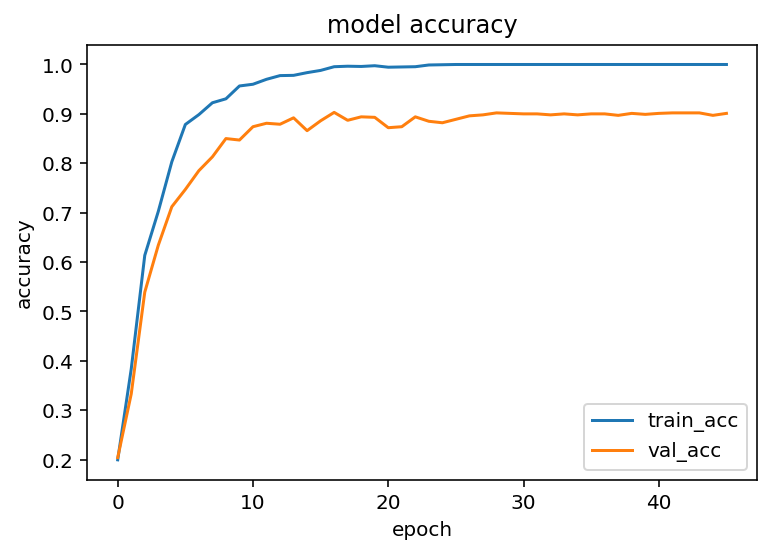

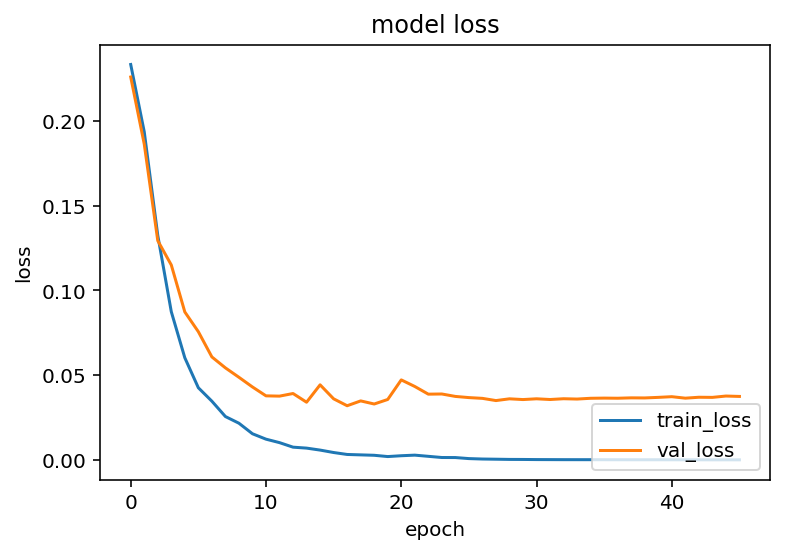

100%|██████████| 114/114 [00:14<00:00,  8.02it/s]
[2017-12-04 20:34:13,317 INFO] Epoch: 0 | TrainAcc: 0.1870 | TrainLoss: 0.2266
[2017-12-04 20:34:13,735 INFO] Epoch: 0 | ValAcc: 0.1830 | ValLoss: 0.2177 

[2017-12-04 20:34:15,134 INFO] Epoch: 1 | TrainAcc: 0.4675 | TrainLoss: 0.1642
[2017-12-04 20:34:15,500 INFO] Epoch: 1 | ValAcc: 0.5960 | ValLoss: 0.1403 

[2017-12-04 20:34:16,862 INFO] Epoch: 2 | TrainAcc: 0.7750 | TrainLoss: 0.0774
[2017-12-04 20:34:17,235 INFO] Epoch: 2 | ValAcc: 0.6210 | ValLoss: 0.1172 

[2017-12-04 20:34:18,577 INFO] Epoch: 3 | TrainAcc: 0.8305 | TrainLoss: 0.0504
[2017-12-04 20:34:18,953 INFO] Epoch: 3 | ValAcc: 0.6610 | ValLoss: 0.1101 

[2017-12-04 20:34:20,700 INFO] Epoch: 4 | TrainAcc: 0.8860 | TrainLoss: 0.0343
[2017-12-04 20:34:21,072 INFO] Epoch: 4 | ValAcc: 0.7880 | ValLoss: 0.0715 

[2017-12-04 20:34:22,430 INFO] Epoch: 5 | TrainAcc: 0.9190 | TrainLoss: 0.0252
[2017-12-04 20:34:22,809 INFO] Epoch: 5 | ValAcc: 0.7760 | ValLoss: 0.0724 

[2017-12-04 20

[2017-12-04 20:35:47,231 INFO] Epoch: 51 | ValAcc: 0.8820 | ValLoss: 0.0494 

[2017-12-04 20:35:48,553 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:35:48,914 INFO] Epoch: 52 | ValAcc: 0.8850 | ValLoss: 0.0492 

[2017-12-04 20:35:50,510 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:35:50,889 INFO] Epoch: 53 | ValAcc: 0.8810 | ValLoss: 0.0495 

[2017-12-04 20:35:52,214 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:35:52,568 INFO] Epoch: 54 | ValAcc: 0.8850 | ValLoss: 0.0493 

[2017-12-04 20:35:53,956 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:35:54,352 INFO] Epoch: 55 | ValAcc: 0.8840 | ValLoss: 0.0497 

[2017-12-04 20:35:55,663 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:35:56,021 INFO] Epoch: 56 | ValAcc: 0.8820 | ValLoss: 0.0496 

[2017-12-04 20:35:57,315 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:35:57,683 INFO] Epoch: 57 | ValAcc: 0

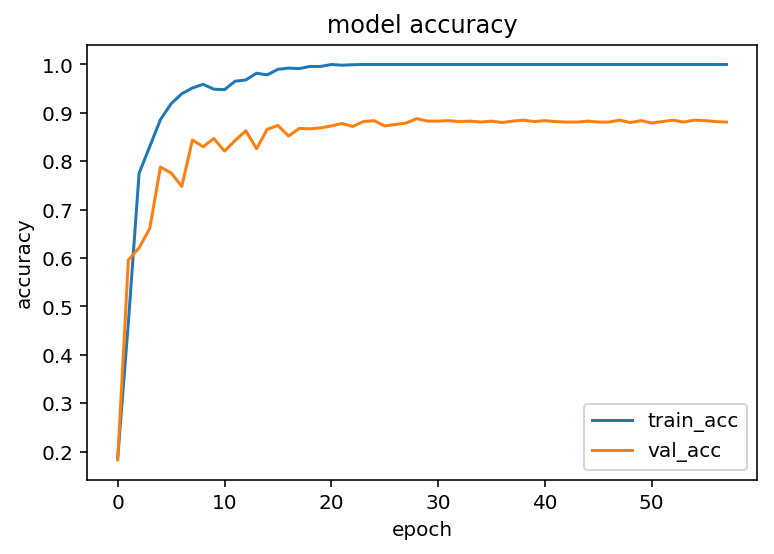

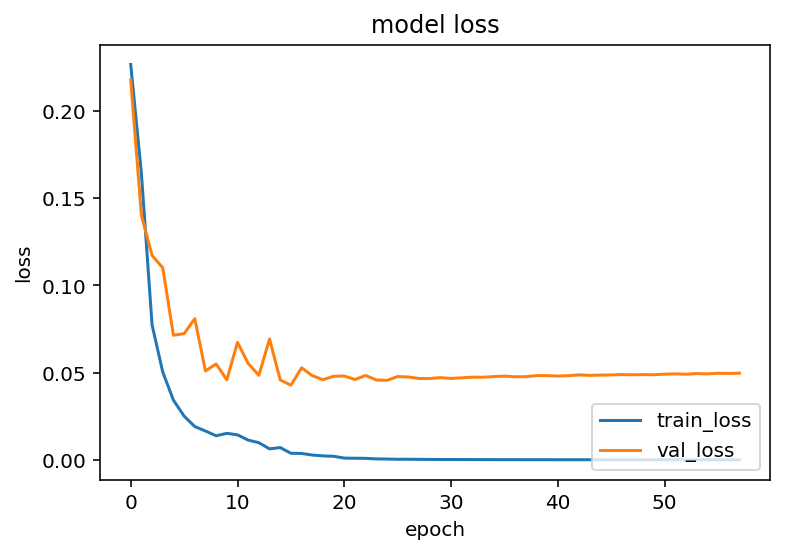

100%|██████████| 114/114 [00:12<00:00,  9.08it/s]
[2017-12-04 20:36:14,191 INFO] Epoch: 0 | TrainAcc: 0.1805 | TrainLoss: 0.2275
[2017-12-04 20:36:14,573 INFO] Epoch: 0 | ValAcc: 0.1550 | ValLoss: 0.2235 

[2017-12-04 20:36:15,876 INFO] Epoch: 1 | TrainAcc: 0.4625 | TrainLoss: 0.1720
[2017-12-04 20:36:16,234 INFO] Epoch: 1 | ValAcc: 0.4910 | ValLoss: 0.1547 

[2017-12-04 20:36:17,596 INFO] Epoch: 2 | TrainAcc: 0.6650 | TrainLoss: 0.1049
[2017-12-04 20:36:17,952 INFO] Epoch: 2 | ValAcc: 0.6410 | ValLoss: 0.1270 

[2017-12-04 20:36:19,229 INFO] Epoch: 3 | TrainAcc: 0.7455 | TrainLoss: 0.0755
[2017-12-04 20:36:19,577 INFO] Epoch: 3 | ValAcc: 0.6410 | ValLoss: 0.1148 

[2017-12-04 20:36:20,848 INFO] Epoch: 4 | TrainAcc: 0.8295 | TrainLoss: 0.0503
[2017-12-04 20:36:21,210 INFO] Epoch: 4 | ValAcc: 0.7790 | ValLoss: 0.0669 

[2017-12-04 20:36:22,458 INFO] Epoch: 5 | TrainAcc: 0.8715 | TrainLoss: 0.0388
[2017-12-04 20:36:22,828 INFO] Epoch: 5 | ValAcc: 0.7040 | ValLoss: 0.0926 

[2017-12-04 20

[2017-12-04 20:44:00,268 INFO] Epoch: 51 | ValAcc: 0.8790 | ValLoss: 0.0551 

[2017-12-04 20:44:01,533 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:44:01,898 INFO] Epoch: 52 | ValAcc: 0.8790 | ValLoss: 0.0548 

[2017-12-04 20:44:03,242 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:44:03,605 INFO] Epoch: 53 | ValAcc: 0.8780 | ValLoss: 0.0558 

[2017-12-04 20:44:03,630 INFO] Accuracy dose not improve for a long epochs
[2017-12-04 20:44:03,632 INFO] Train done.
[2017-12-04 20:44:03,633 INFO] Elapsed Time: 470.68373584747314


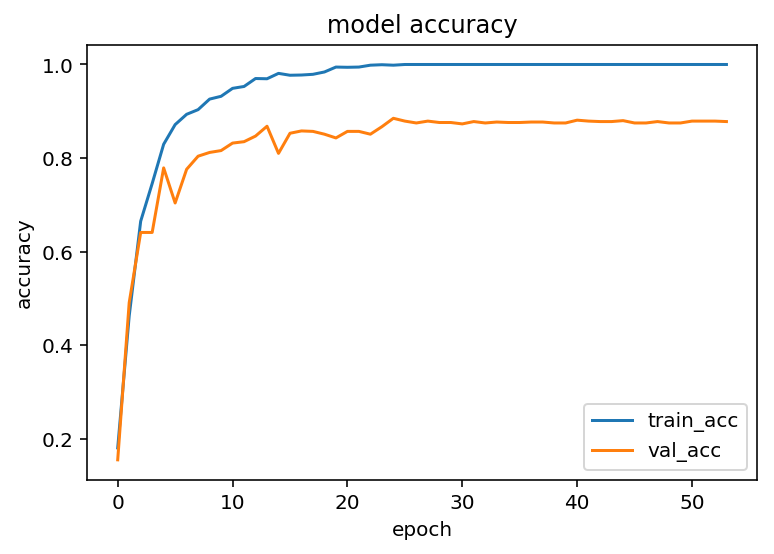

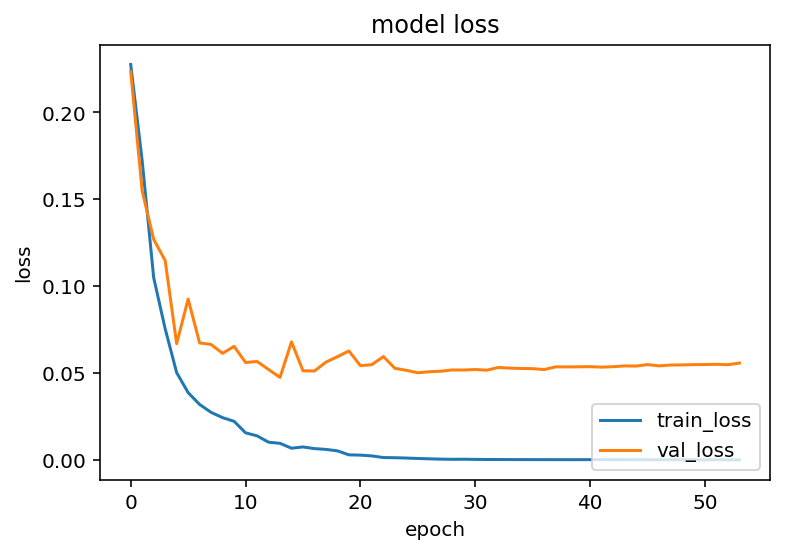

100%|██████████| 114/114 [00:11<00:00,  9.93it/s]
[2017-12-04 20:44:18,869 INFO] Epoch: 0 | TrainAcc: 0.2045 | TrainLoss: 0.2360
[2017-12-04 20:44:19,321 INFO] Epoch: 0 | ValAcc: 0.2420 | ValLoss: 0.2228 

[2017-12-04 20:44:20,495 INFO] Epoch: 1 | TrainAcc: 0.3530 | TrainLoss: 0.1946
[2017-12-04 20:44:20,940 INFO] Epoch: 1 | ValAcc: 0.2810 | ValLoss: 0.1969 

[2017-12-04 20:44:22,124 INFO] Epoch: 2 | TrainAcc: 0.5215 | TrainLoss: 0.1414
[2017-12-04 20:44:22,573 INFO] Epoch: 2 | ValAcc: 0.5340 | ValLoss: 0.1319 

[2017-12-04 20:44:23,799 INFO] Epoch: 3 | TrainAcc: 0.6775 | TrainLoss: 0.0963
[2017-12-04 20:44:24,280 INFO] Epoch: 3 | ValAcc: 0.5560 | ValLoss: 0.1153 

[2017-12-04 20:44:25,498 INFO] Epoch: 4 | TrainAcc: 0.8280 | TrainLoss: 0.0548
[2017-12-04 20:44:25,963 INFO] Epoch: 4 | ValAcc: 0.7580 | ValLoss: 0.0738 

[2017-12-04 20:44:27,155 INFO] Epoch: 5 | TrainAcc: 0.8975 | TrainLoss: 0.0338
[2017-12-04 20:44:27,596 INFO] Epoch: 5 | ValAcc: 0.8040 | ValLoss: 0.0629 

[2017-12-04 20

[2017-12-04 20:55:09,709 INFO] Epoch: 51 | ValAcc: 0.9030 | ValLoss: 0.0376 

[2017-12-04 20:55:11,018 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:55:11,501 INFO] Epoch: 52 | ValAcc: 0.9020 | ValLoss: 0.0376 

[2017-12-04 20:55:12,782 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:55:13,273 INFO] Epoch: 53 | ValAcc: 0.9040 | ValLoss: 0.0380 

[2017-12-04 20:55:14,807 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:55:15,350 INFO] Epoch: 54 | ValAcc: 0.9040 | ValLoss: 0.0375 

[2017-12-04 20:55:15,380 INFO] Accuracy dose not improve for a long epochs
[2017-12-04 20:55:15,382 INFO] Train done.
[2017-12-04 20:55:15,384 INFO] Elapsed Time: 657.6827871799469


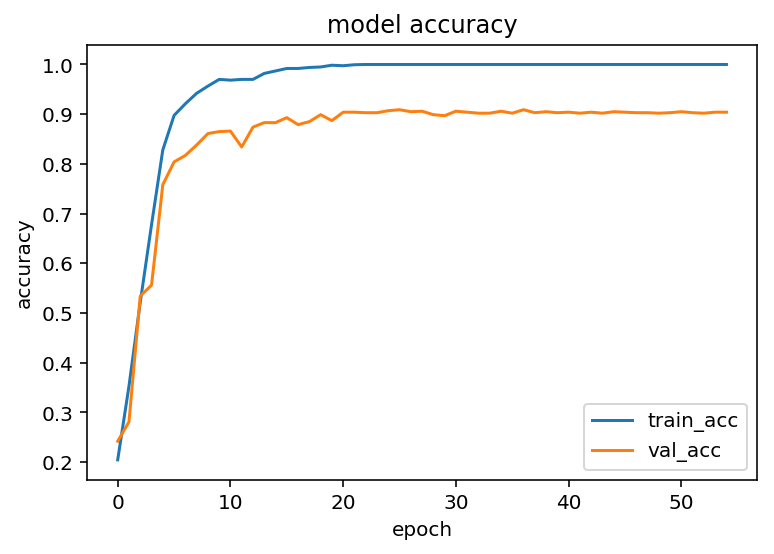

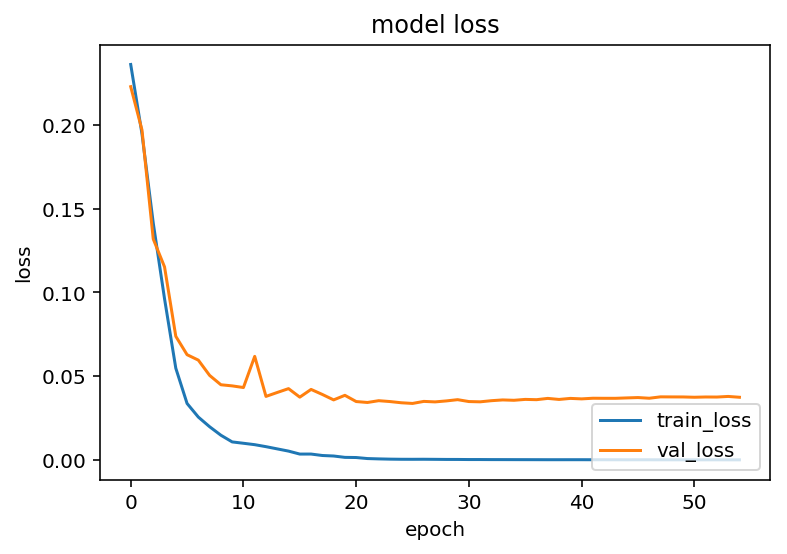

100%|██████████| 114/114 [00:14<00:00,  7.78it/s]
[2017-12-04 20:55:34,477 INFO] Epoch: 0 | TrainAcc: 0.2145 | TrainLoss: 0.2276
[2017-12-04 20:55:34,853 INFO] Epoch: 0 | ValAcc: 0.2810 | ValLoss: 0.2147 

[2017-12-04 20:55:36,477 INFO] Epoch: 1 | TrainAcc: 0.4805 | TrainLoss: 0.1536
[2017-12-04 20:55:36,847 INFO] Epoch: 1 | ValAcc: 0.4370 | ValLoss: 0.1436 

[2017-12-04 20:55:38,159 INFO] Epoch: 2 | TrainAcc: 0.7510 | TrainLoss: 0.0804
[2017-12-04 20:55:38,561 INFO] Epoch: 2 | ValAcc: 0.6830 | ValLoss: 0.0950 

[2017-12-04 20:55:39,860 INFO] Epoch: 3 | TrainAcc: 0.8735 | TrainLoss: 0.0423
[2017-12-04 20:55:40,251 INFO] Epoch: 3 | ValAcc: 0.7670 | ValLoss: 0.0750 

[2017-12-04 20:55:41,587 INFO] Epoch: 4 | TrainAcc: 0.9035 | TrainLoss: 0.0316
[2017-12-04 20:55:41,977 INFO] Epoch: 4 | ValAcc: 0.8380 | ValLoss: 0.0498 

[2017-12-04 20:55:43,529 INFO] Epoch: 5 | TrainAcc: 0.9215 | TrainLoss: 0.0247
[2017-12-04 20:55:43,901 INFO] Epoch: 5 | ValAcc: 0.7580 | ValLoss: 0.0781 

[2017-12-04 20

[2017-12-04 20:57:04,852 INFO] Epoch: 51 | ValAcc: 0.9100 | ValLoss: 0.0380 

[2017-12-04 20:57:06,111 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:57:06,461 INFO] Epoch: 52 | ValAcc: 0.9080 | ValLoss: 0.0379 

[2017-12-04 20:57:07,713 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:57:08,084 INFO] Epoch: 53 | ValAcc: 0.9080 | ValLoss: 0.0378 

[2017-12-04 20:57:09,371 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:57:09,723 INFO] Epoch: 54 | ValAcc: 0.9110 | ValLoss: 0.0380 

[2017-12-04 20:57:10,952 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:57:11,316 INFO] Epoch: 55 | ValAcc: 0.9100 | ValLoss: 0.0384 

[2017-12-04 20:57:12,573 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:57:12,941 INFO] Epoch: 56 | ValAcc: 0.9090 | ValLoss: 0.0382 

[2017-12-04 20:57:14,201 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:57:14,578 INFO] Epoch: 57 | ValAcc: 0

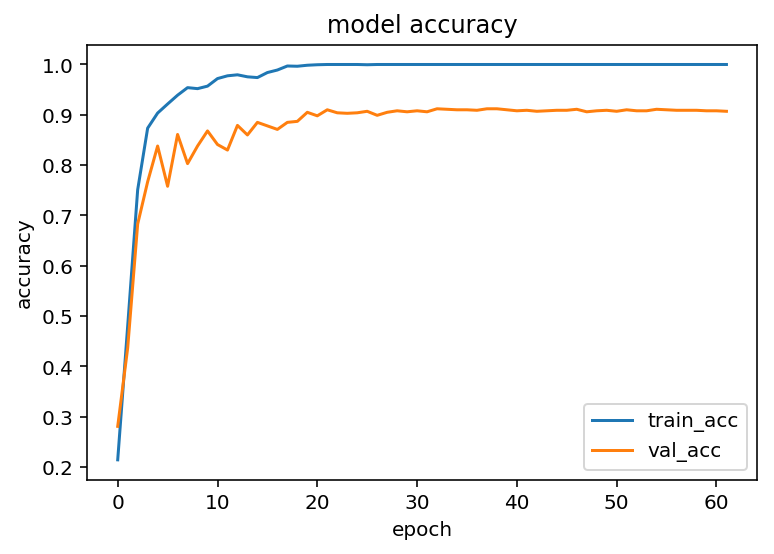

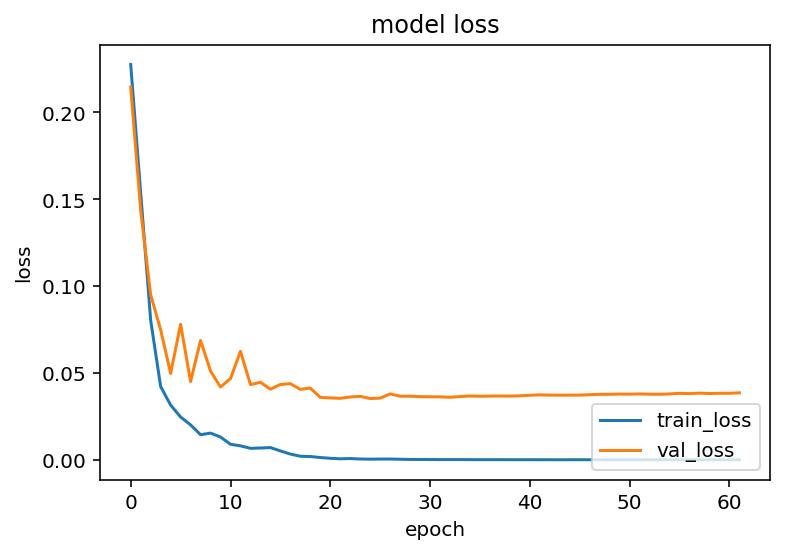

100%|██████████| 114/114 [00:12<00:00,  9.25it/s]
[2017-12-04 20:57:37,559 INFO] Epoch: 0 | TrainAcc: 0.2060 | TrainLoss: 0.2308
[2017-12-04 20:57:37,926 INFO] Epoch: 0 | ValAcc: 0.3060 | ValLoss: 0.2135 

[2017-12-04 20:57:39,215 INFO] Epoch: 1 | TrainAcc: 0.4380 | TrainLoss: 0.1770
[2017-12-04 20:57:39,574 INFO] Epoch: 1 | ValAcc: 0.3470 | ValLoss: 0.1813 

[2017-12-04 20:57:40,844 INFO] Epoch: 2 | TrainAcc: 0.6330 | TrainLoss: 0.1133
[2017-12-04 20:57:41,219 INFO] Epoch: 2 | ValAcc: 0.6030 | ValLoss: 0.1108 

[2017-12-04 20:57:42,516 INFO] Epoch: 3 | TrainAcc: 0.7315 | TrainLoss: 0.0776
[2017-12-04 20:57:42,870 INFO] Epoch: 3 | ValAcc: 0.6160 | ValLoss: 0.1144 

[2017-12-04 20:57:44,147 INFO] Epoch: 4 | TrainAcc: 0.8200 | TrainLoss: 0.0552
[2017-12-04 20:57:44,517 INFO] Epoch: 4 | ValAcc: 0.5110 | ValLoss: 0.2022 

[2017-12-04 20:57:45,790 INFO] Epoch: 5 | TrainAcc: 0.8810 | TrainLoss: 0.0404
[2017-12-04 20:57:46,139 INFO] Epoch: 5 | ValAcc: 0.7730 | ValLoss: 0.0729 

[2017-12-04 20

[2017-12-04 20:59:02,044 INFO] Epoch: 51 | ValAcc: 0.9030 | ValLoss: 0.0384 

[2017-12-04 20:59:03,308 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:59:03,664 INFO] Epoch: 52 | ValAcc: 0.9000 | ValLoss: 0.0386 

[2017-12-04 20:59:04,951 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:59:05,326 INFO] Epoch: 53 | ValAcc: 0.9000 | ValLoss: 0.0381 

[2017-12-04 20:59:06,599 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:59:06,947 INFO] Epoch: 54 | ValAcc: 0.9020 | ValLoss: 0.0385 

[2017-12-04 20:59:08,199 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:59:08,547 INFO] Epoch: 55 | ValAcc: 0.9020 | ValLoss: 0.0386 

[2017-12-04 20:59:09,844 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:59:10,217 INFO] Epoch: 56 | ValAcc: 0.9020 | ValLoss: 0.0387 

[2017-12-04 20:59:11,479 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 20:59:11,841 INFO] Epoch: 57 | ValAcc: 0

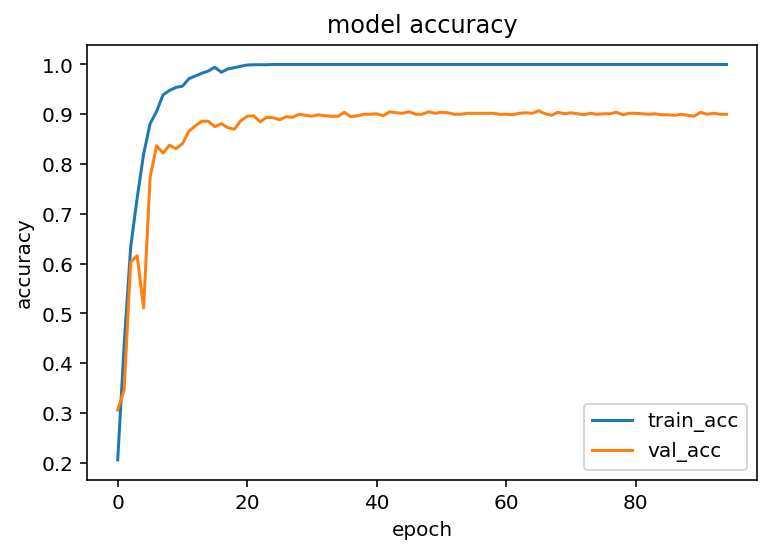

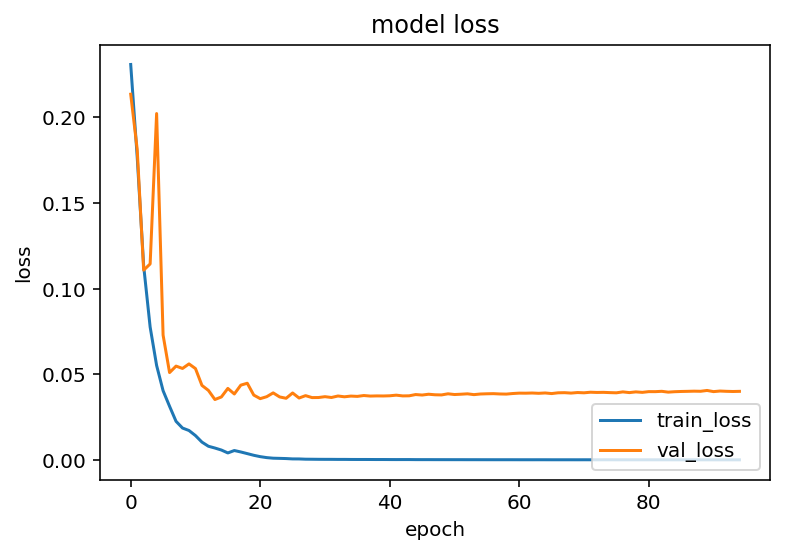

100%|██████████| 114/114 [00:12<00:00,  9.21it/s]
[2017-12-04 21:00:29,623 INFO] Epoch: 0 | TrainAcc: 0.2445 | TrainLoss: 0.2183
[2017-12-04 21:00:29,999 INFO] Epoch: 0 | ValAcc: 0.3140 | ValLoss: 0.2074 

[2017-12-04 21:00:31,284 INFO] Epoch: 1 | TrainAcc: 0.5055 | TrainLoss: 0.1521
[2017-12-04 21:00:31,638 INFO] Epoch: 1 | ValAcc: 0.5020 | ValLoss: 0.1517 

[2017-12-04 21:00:32,932 INFO] Epoch: 2 | TrainAcc: 0.6805 | TrainLoss: 0.0988
[2017-12-04 21:00:33,313 INFO] Epoch: 2 | ValAcc: 0.5270 | ValLoss: 0.1350 

[2017-12-04 21:00:34,630 INFO] Epoch: 3 | TrainAcc: 0.7945 | TrainLoss: 0.0625
[2017-12-04 21:00:34,993 INFO] Epoch: 3 | ValAcc: 0.7000 | ValLoss: 0.0966 

[2017-12-04 21:00:36,277 INFO] Epoch: 4 | TrainAcc: 0.8895 | TrainLoss: 0.0363
[2017-12-04 21:00:36,629 INFO] Epoch: 4 | ValAcc: 0.7250 | ValLoss: 0.0935 

[2017-12-04 21:00:37,935 INFO] Epoch: 5 | TrainAcc: 0.9180 | TrainLoss: 0.0272
[2017-12-04 21:00:38,305 INFO] Epoch: 5 | ValAcc: 0.8040 | ValLoss: 0.0634 

[2017-12-04 21

[2017-12-04 21:01:53,010 INFO] Train done.
[2017-12-04 21:01:53,012 INFO] Elapsed Time: 84.62626504898071


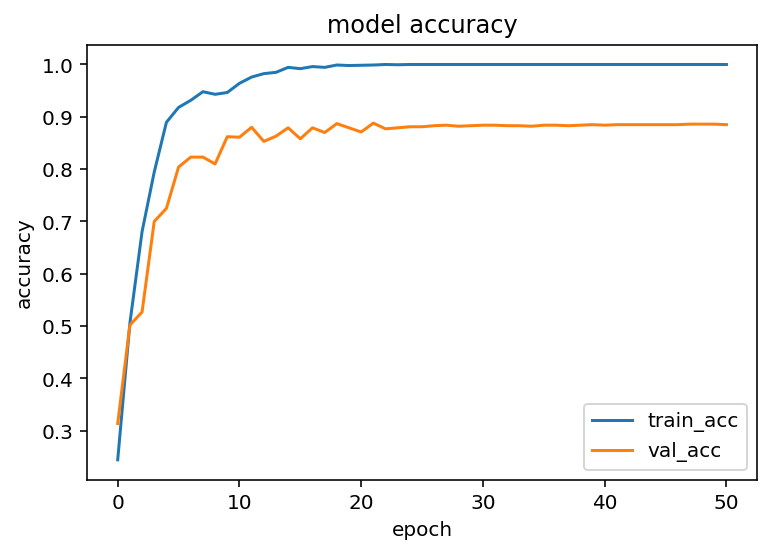

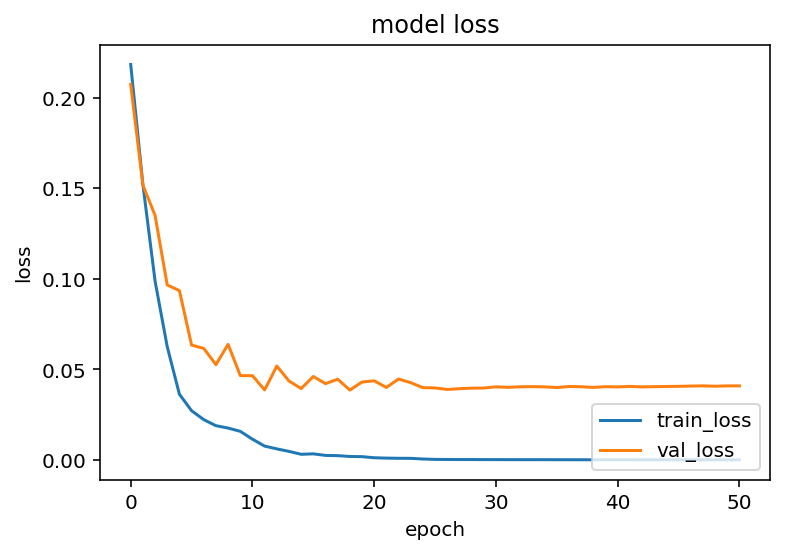

100%|██████████| 114/114 [00:12<00:00,  9.13it/s]
[2017-12-04 21:02:09,438 INFO] Epoch: 0 | TrainAcc: 0.1670 | TrainLoss: 0.2349
[2017-12-04 21:02:09,802 INFO] Epoch: 0 | ValAcc: 0.2860 | ValLoss: 0.2188 

[2017-12-04 21:02:11,073 INFO] Epoch: 1 | TrainAcc: 0.4775 | TrainLoss: 0.1741
[2017-12-04 21:02:11,425 INFO] Epoch: 1 | ValAcc: 0.4990 | ValLoss: 0.1630 

[2017-12-04 21:02:12,784 INFO] Epoch: 2 | TrainAcc: 0.6295 | TrainLoss: 0.1117
[2017-12-04 21:02:13,152 INFO] Epoch: 2 | ValAcc: 0.6170 | ValLoss: 0.1219 

[2017-12-04 21:02:14,400 INFO] Epoch: 3 | TrainAcc: 0.7455 | TrainLoss: 0.0760
[2017-12-04 21:02:14,751 INFO] Epoch: 3 | ValAcc: 0.6300 | ValLoss: 0.1022 

[2017-12-04 21:02:16,015 INFO] Epoch: 4 | TrainAcc: 0.8255 | TrainLoss: 0.0526
[2017-12-04 21:02:16,368 INFO] Epoch: 4 | ValAcc: 0.7020 | ValLoss: 0.0860 

[2017-12-04 21:02:17,699 INFO] Epoch: 5 | TrainAcc: 0.8295 | TrainLoss: 0.0499
[2017-12-04 21:02:18,055 INFO] Epoch: 5 | ValAcc: 0.7510 | ValLoss: 0.0763 

[2017-12-04 21

[2017-12-04 21:03:33,863 INFO] Epoch: 51 | ValAcc: 0.8970 | ValLoss: 0.0423 

[2017-12-04 21:03:35,142 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 21:03:35,510 INFO] Epoch: 52 | ValAcc: 0.8940 | ValLoss: 0.0419 

[2017-12-04 21:03:36,768 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 21:03:37,124 INFO] Epoch: 53 | ValAcc: 0.8950 | ValLoss: 0.0425 

[2017-12-04 21:03:38,397 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 21:03:38,754 INFO] Epoch: 54 | ValAcc: 0.8930 | ValLoss: 0.0426 

[2017-12-04 21:03:40,031 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 21:03:40,403 INFO] Epoch: 55 | ValAcc: 0.8940 | ValLoss: 0.0423 

[2017-12-04 21:03:41,718 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 21:03:42,078 INFO] Epoch: 56 | ValAcc: 0.8950 | ValLoss: 0.0420 

[2017-12-04 21:03:43,363 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 21:03:43,722 INFO] Epoch: 57 | ValAcc: 0

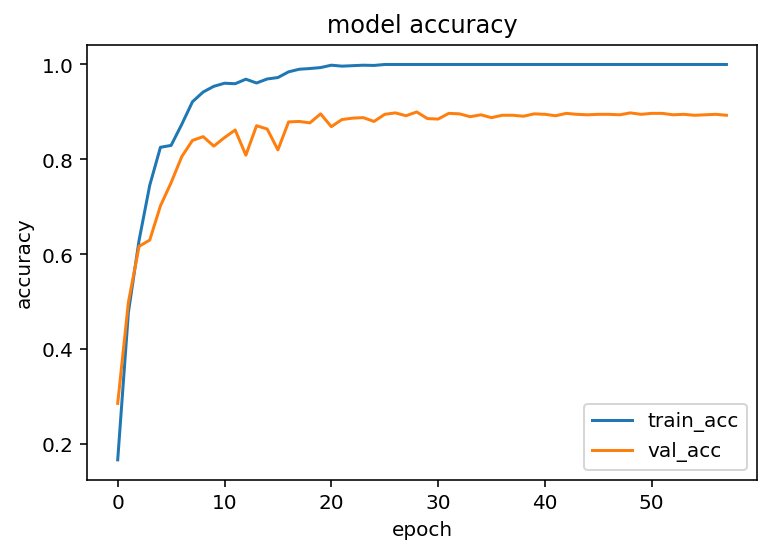

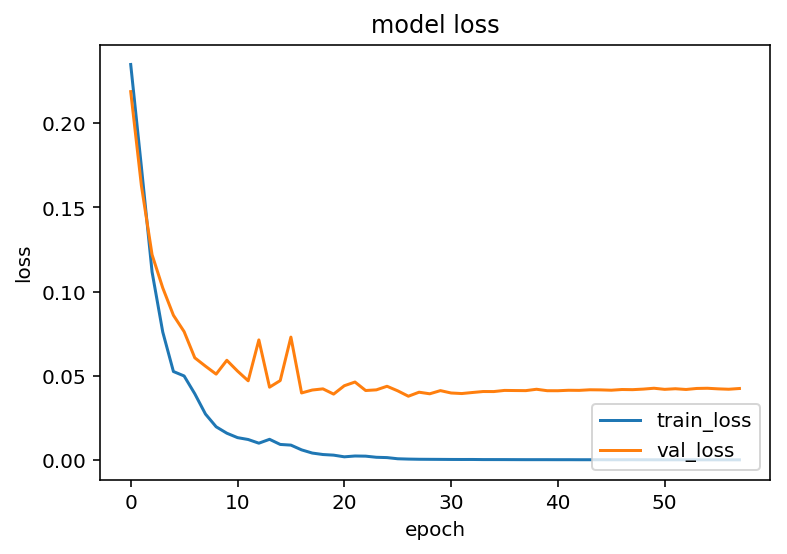

100%|██████████| 114/114 [00:12<00:00,  9.25it/s]
[2017-12-04 21:04:00,003 INFO] Epoch: 0 | TrainAcc: 0.2150 | TrainLoss: 0.2245
[2017-12-04 21:04:00,366 INFO] Epoch: 0 | ValAcc: 0.1620 | ValLoss: 0.2165 

[2017-12-04 21:04:01,637 INFO] Epoch: 1 | TrainAcc: 0.5270 | TrainLoss: 0.1569
[2017-12-04 21:04:02,024 INFO] Epoch: 1 | ValAcc: 0.4200 | ValLoss: 0.1618 

[2017-12-04 21:04:03,398 INFO] Epoch: 2 | TrainAcc: 0.7265 | TrainLoss: 0.0883
[2017-12-04 21:04:03,752 INFO] Epoch: 2 | ValAcc: 0.6660 | ValLoss: 0.0918 

[2017-12-04 21:04:05,017 INFO] Epoch: 3 | TrainAcc: 0.8440 | TrainLoss: 0.0480
[2017-12-04 21:04:05,379 INFO] Epoch: 3 | ValAcc: 0.7130 | ValLoss: 0.0910 

[2017-12-04 21:04:06,656 INFO] Epoch: 4 | TrainAcc: 0.8790 | TrainLoss: 0.0370
[2017-12-04 21:04:07,025 INFO] Epoch: 4 | ValAcc: 0.7350 | ValLoss: 0.0843 

[2017-12-04 21:04:08,301 INFO] Epoch: 5 | TrainAcc: 0.9220 | TrainLoss: 0.0251
[2017-12-04 21:04:08,653 INFO] Epoch: 5 | ValAcc: 0.8180 | ValLoss: 0.0591 

[2017-12-04 21

[2017-12-04 21:05:24,487 INFO] Epoch: 51 | ValAcc: 0.9020 | ValLoss: 0.0378 

[2017-12-04 21:05:25,791 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 21:05:26,142 INFO] Epoch: 52 | ValAcc: 0.9050 | ValLoss: 0.0379 

[2017-12-04 21:05:27,410 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 21:05:27,767 INFO] Epoch: 53 | ValAcc: 0.9020 | ValLoss: 0.0380 

[2017-12-04 21:05:29,042 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 21:05:29,403 INFO] Epoch: 54 | ValAcc: 0.9050 | ValLoss: 0.0382 

[2017-12-04 21:05:30,728 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 21:05:31,104 INFO] Epoch: 55 | ValAcc: 0.9040 | ValLoss: 0.0380 

[2017-12-04 21:05:32,388 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 21:05:32,743 INFO] Epoch: 56 | ValAcc: 0.9030 | ValLoss: 0.0383 

[2017-12-04 21:05:34,022 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 21:05:34,386 INFO] Epoch: 57 | ValAcc: 0

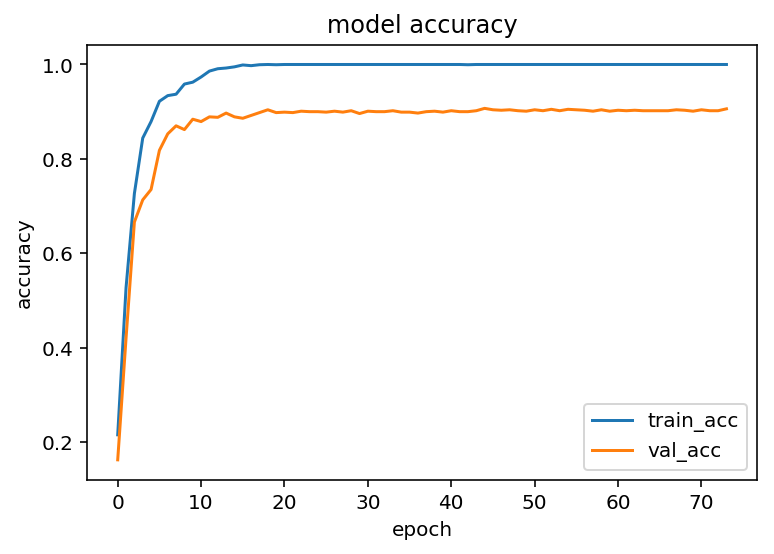

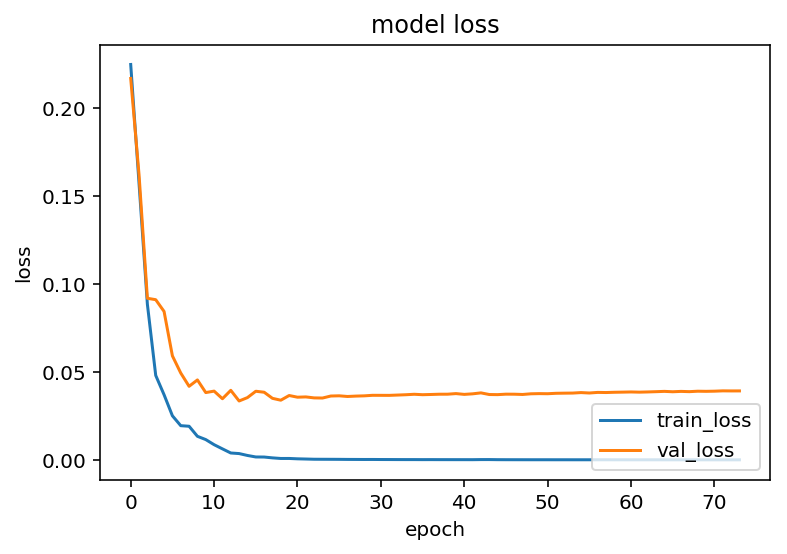

100%|██████████| 114/114 [00:12<00:00,  9.20it/s]
[2017-12-04 21:06:17,223 INFO] Epoch: 0 | TrainAcc: 0.1220 | TrainLoss: 0.2372
[2017-12-04 21:06:17,591 INFO] Epoch: 0 | ValAcc: 0.1000 | ValLoss: 0.2285 

[2017-12-04 21:06:18,853 INFO] Epoch: 1 | TrainAcc: 0.2390 | TrainLoss: 0.2189
[2017-12-04 21:06:19,221 INFO] Epoch: 1 | ValAcc: 0.1760 | ValLoss: 0.2160 

[2017-12-04 21:06:20,510 INFO] Epoch: 2 | TrainAcc: 0.3075 | TrainLoss: 0.1891
[2017-12-04 21:06:20,866 INFO] Epoch: 2 | ValAcc: 0.4150 | ValLoss: 0.1842 

[2017-12-04 21:06:22,131 INFO] Epoch: 3 | TrainAcc: 0.5085 | TrainLoss: 0.1464
[2017-12-04 21:06:22,484 INFO] Epoch: 3 | ValAcc: 0.4090 | ValLoss: 0.1529 

[2017-12-04 21:06:23,789 INFO] Epoch: 4 | TrainAcc: 0.6960 | TrainLoss: 0.0948
[2017-12-04 21:06:24,154 INFO] Epoch: 4 | ValAcc: 0.6060 | ValLoss: 0.1195 

[2017-12-04 21:06:25,441 INFO] Epoch: 5 | TrainAcc: 0.8120 | TrainLoss: 0.0626
[2017-12-04 21:06:25,824 INFO] Epoch: 5 | ValAcc: 0.7010 | ValLoss: 0.0903 

[2017-12-04 21

[2017-12-04 21:27:55,853 INFO] Epoch: 51 | ValAcc: 0.8990 | ValLoss: 0.0449 

[2017-12-04 21:27:57,241 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 21:27:57,674 INFO] Epoch: 52 | ValAcc: 0.8950 | ValLoss: 0.0456 

[2017-12-04 21:27:59,184 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-04 21:27:56,351 INFO] Epoch: 53 | ValAcc: 0.8970 | ValLoss: 0.0452 

[2017-12-04 21:27:57,908 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 21:27:58,339 INFO] Epoch: 54 | ValAcc: 0.8990 | ValLoss: 0.0457 

[2017-12-04 21:27:59,887 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 21:28:00,400 INFO] Epoch: 55 | ValAcc: 0.8970 | ValLoss: 0.0452 

[2017-12-04 21:28:01,942 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 21:28:02,402 INFO] Epoch: 56 | ValAcc: 0.8990 | ValLoss: 0.0454 

[2017-12-04 21:28:03,868 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-04 21:28:04,271 INFO] Epoch: 57 | ValAcc: 0

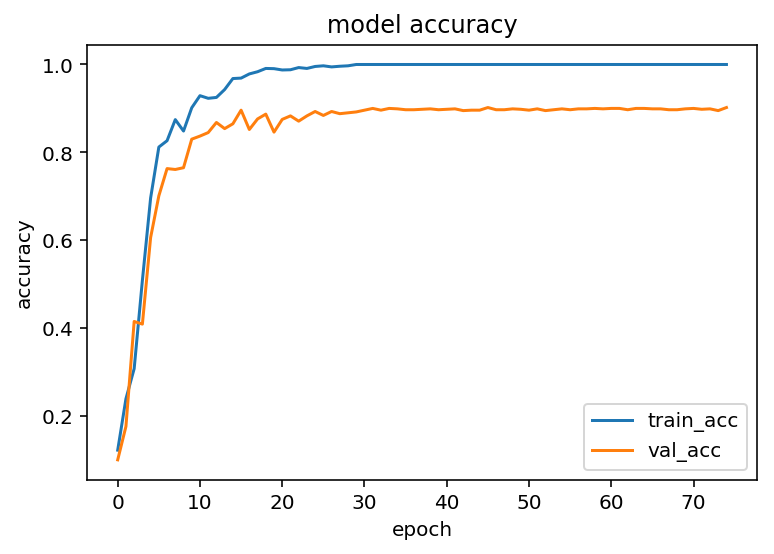

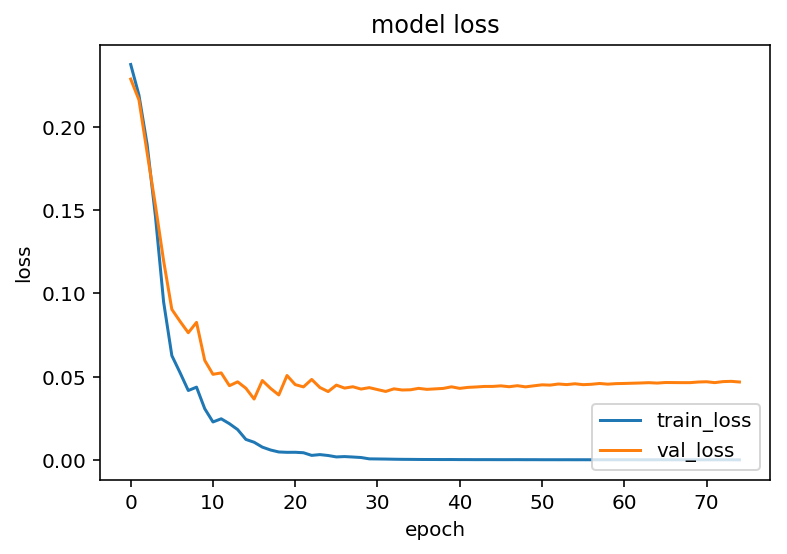

100%|██████████| 114/114 [00:12<00:00,  9.18it/s]


In [41]:
# set experimental params
epochs = 1000
lr = 0.5
momentum = 0.9
ratio_pl = 1.0 # ratio of train:pseudo
hard = True
ex_name = 'accurate_pseudo'
trial_times = 10

logzero.logfile('./log/{}.log'.format(ex_name))

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

results = {}
results['test_acc'] = np.empty((trial_times))
results['test_loss'] = np.empty((trial_times))
results['unlabeled_acc'] = np.empty((trial_times))
results['unlabeled_loss'] = np.empty((trial_times))
for i in range(trial_times):
    train_dataset = MNISTDatasetForPseudoLabeling(
        X_train, y_train, X_pseudo, y_pseudo, ratio_pl, hard, transform)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_dataset = MNISTDataset(X_val, y_val, transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=test_batch_size, num_workers=num_workers)
    test_dataset = MNISTDataset(X_test, y_test, transform)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, num_workers=num_workers)
    unlabeled_dataset = MNISTDataset(X_unlabeled, y_unlabeled, transform)
    unlabeled_loader = torch.utils.data.DataLoader(
        unlabeled_dataset, batch_size=test_batch_size, num_workers=num_workers)

    model = Net()
    if use_gpu:
        model.cuda()

    def save_checkpoint(state, filename='./save/checkpoint_{}.pth'.format(ex_name)):
        torch.save(state, filename)

    criterion = nn.KLDivLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    tracker = TrainingTracker()

    start = time.time()

    for epoch in range(0, epochs):
        tracker.epoch = epoch

        _train(model, train_loader, criterion, optimizer, tracker)
        _validate(model, val_loader, criterion, tracker)

        # if latest accuracy is the best in history
        if len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) == 1:
            save_checkpoint({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            })
        elif len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) >= 30:
            logger.info('Accuracy dose not improve for a long epochs')
            break

    logger.info('Train done.')
    logger.info('Elapsed Time: {}'.format(time.time() - start))
    tracker.plot_history()
    
    model = Net()
    resume = torch.load('./save/checkpoint_{}.pth'.format(ex_name))
    model.load_state_dict(resume['state_dict'])
    results['test_acc'][i], results['test_loss'][i] = _test(model, test_loader, criterion)
    results['unlabeled_acc'][i], results['unlabeled_loss'][i] = \
        _test(model, unlabeled_loader, criterion)

In [42]:
logger.info('Test Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results['test_acc']),
    np.std(results['test_acc'])
))
logger.info('Test Loss: {:.4f} ± {:.4f}\n'.format(
    np.mean(results['test_loss']),
    np.std(results['test_loss'])
))

logger.info('Unlabeled Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results['unlabeled_acc']),
    np.std(results['unlabeled_acc'])
))
logger.info('Unlabeled Loss: {:.4f} ± {:.4f}'.format(
    np.mean(results['unlabeled_loss']),
    np.std(results['unlabeled_loss'])
))

[2017-12-04 21:28:49,273 INFO] Test Accuracy: 0.9096 ± 0.0071
[2017-12-04 21:28:49,275 INFO] Test Loss: 0.0339 ± 0.0026

[2017-12-04 21:28:49,278 INFO] Unlabeled Accuracy: 0.9021 ± 0.0070
[2017-12-04 21:28:49,279 INFO] Unlabeled Loss: 0.0372 ± 0.0028


In [43]:
from scipy import stats

t, p = stats.ttest_ind(results['test_acc'], results['unlabeled_acc'], equal_var=False)
print( "p値 = %(p)s" %locals() )

p値 = 0.0368946240408


## Soft Pseudo Label

[2017-12-04 21:41:06,777 INFO] Epoch: 0 | TrainAcc: 0.2205 | TrainLoss: 0.2234
[2017-12-04 21:41:07,265 INFO] Epoch: 0 | ValAcc: 0.1910 | ValLoss: 0.2160 

[2017-12-04 21:41:08,634 INFO] Epoch: 1 | TrainAcc: 0.4520 | TrainLoss: 0.1664
[2017-12-04 21:41:09,036 INFO] Epoch: 1 | ValAcc: 0.4250 | ValLoss: 0.1546 

[2017-12-04 21:41:10,424 INFO] Epoch: 2 | TrainAcc: 0.6720 | TrainLoss: 0.0987
[2017-12-04 21:41:10,812 INFO] Epoch: 2 | ValAcc: 0.5840 | ValLoss: 0.1238 

[2017-12-04 21:41:12,294 INFO] Epoch: 3 | TrainAcc: 0.8250 | TrainLoss: 0.0594
[2017-12-04 21:41:12,674 INFO] Epoch: 3 | ValAcc: 0.5600 | ValLoss: 0.1390 

[2017-12-04 21:41:14,268 INFO] Epoch: 4 | TrainAcc: 0.8905 | TrainLoss: 0.0361
[2017-12-04 21:41:14,726 INFO] Epoch: 4 | ValAcc: 0.7530 | ValLoss: 0.0706 

[2017-12-04 21:41:16,216 INFO] Epoch: 5 | TrainAcc: 0.9295 | TrainLoss: 0.0263
[2017-12-04 21:41:16,622 INFO] Epoch: 5 | ValAcc: 0.7920 | ValLoss: 0.0609 

[2017-12-04 21:41:18,105 INFO] Epoch: 6 | TrainAcc: 0.9345 | Tra

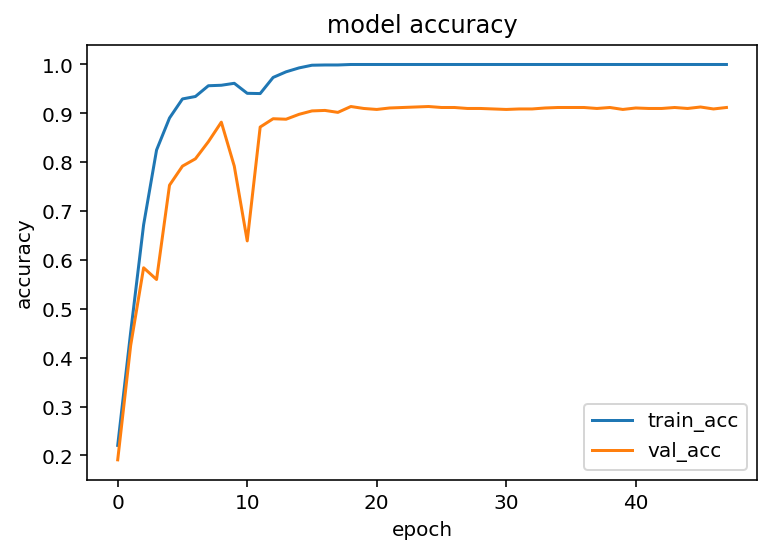

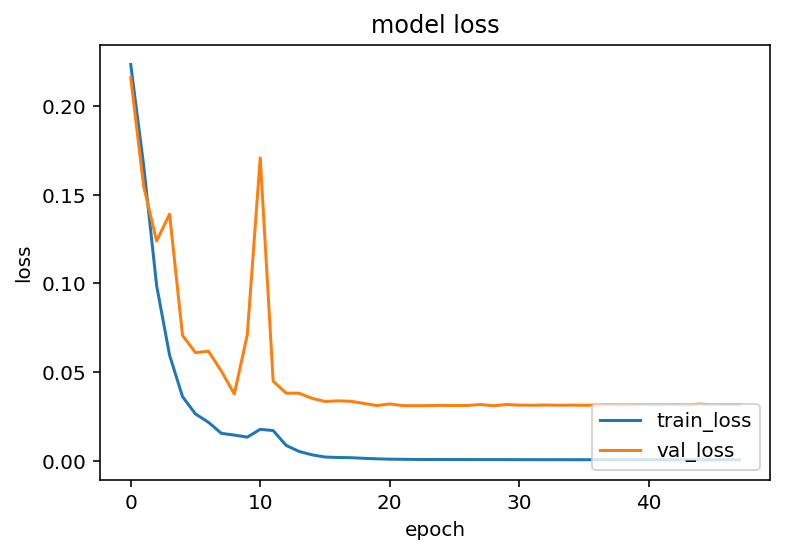

100%|██████████| 114/114 [00:14<00:00,  7.91it/s]
[2017-12-04 21:42:52,396 INFO] Epoch: 0 | TrainAcc: 0.1455 | TrainLoss: 0.2511
[2017-12-04 21:42:52,799 INFO] Epoch: 0 | ValAcc: 0.2700 | ValLoss: 0.2270 

[2017-12-04 21:42:54,167 INFO] Epoch: 1 | TrainAcc: 0.2910 | TrainLoss: 0.2064
[2017-12-04 21:42:54,578 INFO] Epoch: 1 | ValAcc: 0.3600 | ValLoss: 0.1976 

[2017-12-04 21:42:55,988 INFO] Epoch: 2 | TrainAcc: 0.4465 | TrainLoss: 0.1609
[2017-12-04 21:42:56,355 INFO] Epoch: 2 | ValAcc: 0.4930 | ValLoss: 0.1577 

[2017-12-04 21:42:57,708 INFO] Epoch: 3 | TrainAcc: 0.6600 | TrainLoss: 0.1057
[2017-12-04 21:42:58,061 INFO] Epoch: 3 | ValAcc: 0.5380 | ValLoss: 0.1424 

[2017-12-04 21:42:59,378 INFO] Epoch: 4 | TrainAcc: 0.7460 | TrainLoss: 0.0762
[2017-12-04 21:42:59,801 INFO] Epoch: 4 | ValAcc: 0.4980 | ValLoss: 0.1948 

[2017-12-04 21:43:01,269 INFO] Epoch: 5 | TrainAcc: 0.8360 | TrainLoss: 0.0530
[2017-12-04 21:43:01,677 INFO] Epoch: 5 | ValAcc: 0.7150 | ValLoss: 0.0870 

[2017-12-04 21

[2017-12-04 21:44:18,747 INFO] Epoch: 51 | ValAcc: 0.8770 | ValLoss: 0.0504 

[2017-12-04 21:44:20,040 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:44:20,396 INFO] Epoch: 52 | ValAcc: 0.8780 | ValLoss: 0.0504 

[2017-12-04 21:44:21,701 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:44:22,073 INFO] Epoch: 53 | ValAcc: 0.8770 | ValLoss: 0.0503 

[2017-12-04 21:44:23,386 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:44:23,743 INFO] Epoch: 54 | ValAcc: 0.8780 | ValLoss: 0.0507 

[2017-12-04 21:44:25,046 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:44:25,408 INFO] Epoch: 55 | ValAcc: 0.8790 | ValLoss: 0.0501 

[2017-12-04 21:44:26,743 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:44:27,105 INFO] Epoch: 56 | ValAcc: 0.8760 | ValLoss: 0.0502 

[2017-12-04 21:44:28,400 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:44:28,755 INFO] Epoch: 57 | ValAcc: 0

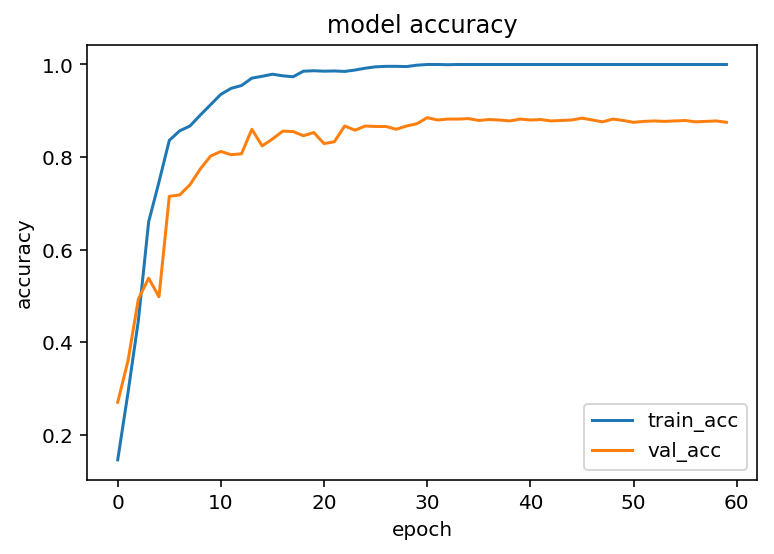

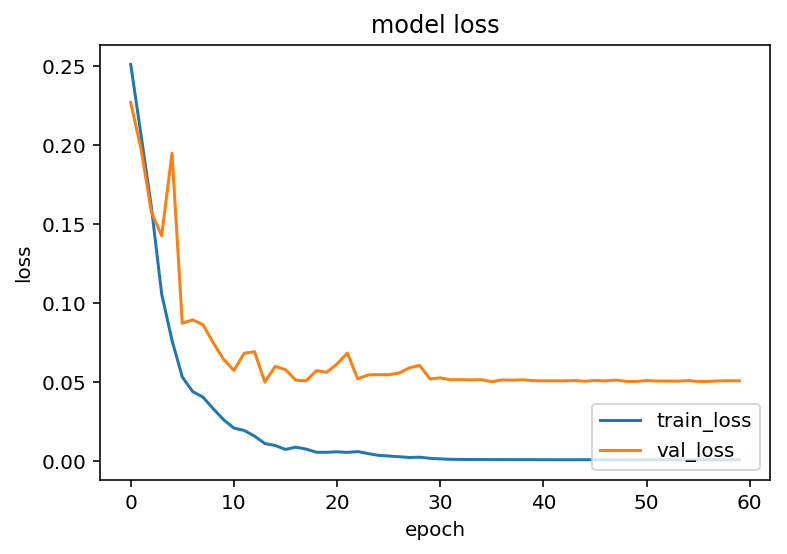

100%|██████████| 114/114 [00:11<00:00,  9.64it/s]
[2017-12-04 21:44:47,848 INFO] Epoch: 0 | TrainAcc: 0.2240 | TrainLoss: 0.2274
[2017-12-04 21:44:48,223 INFO] Epoch: 0 | ValAcc: 0.2570 | ValLoss: 0.2206 

[2017-12-04 21:44:49,511 INFO] Epoch: 1 | TrainAcc: 0.4355 | TrainLoss: 0.1712
[2017-12-04 21:44:49,865 INFO] Epoch: 1 | ValAcc: 0.4910 | ValLoss: 0.1581 

[2017-12-04 21:44:51,137 INFO] Epoch: 2 | TrainAcc: 0.6545 | TrainLoss: 0.1082
[2017-12-04 21:44:51,491 INFO] Epoch: 2 | ValAcc: 0.5230 | ValLoss: 0.1385 

[2017-12-04 21:44:52,796 INFO] Epoch: 3 | TrainAcc: 0.7880 | TrainLoss: 0.0662
[2017-12-04 21:44:53,149 INFO] Epoch: 3 | ValAcc: 0.5590 | ValLoss: 0.1410 

[2017-12-04 21:44:54,447 INFO] Epoch: 4 | TrainAcc: 0.8640 | TrainLoss: 0.0446
[2017-12-04 21:44:54,803 INFO] Epoch: 4 | ValAcc: 0.7850 | ValLoss: 0.0682 

[2017-12-04 21:44:56,092 INFO] Epoch: 5 | TrainAcc: 0.9100 | TrainLoss: 0.0302
[2017-12-04 21:44:56,459 INFO] Epoch: 5 | ValAcc: 0.7270 | ValLoss: 0.0853 

[2017-12-04 21

[2017-12-04 21:46:11,153 INFO] Train done.
[2017-12-04 21:46:11,154 INFO] Elapsed Time: 84.56006503105164


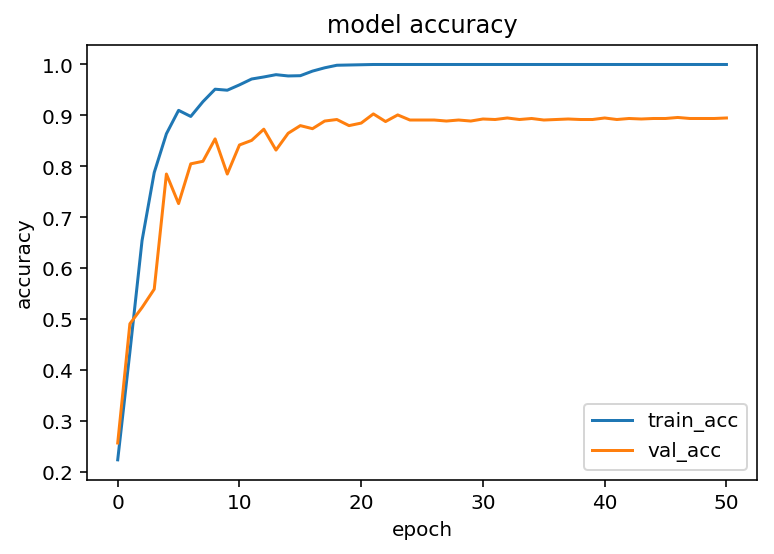

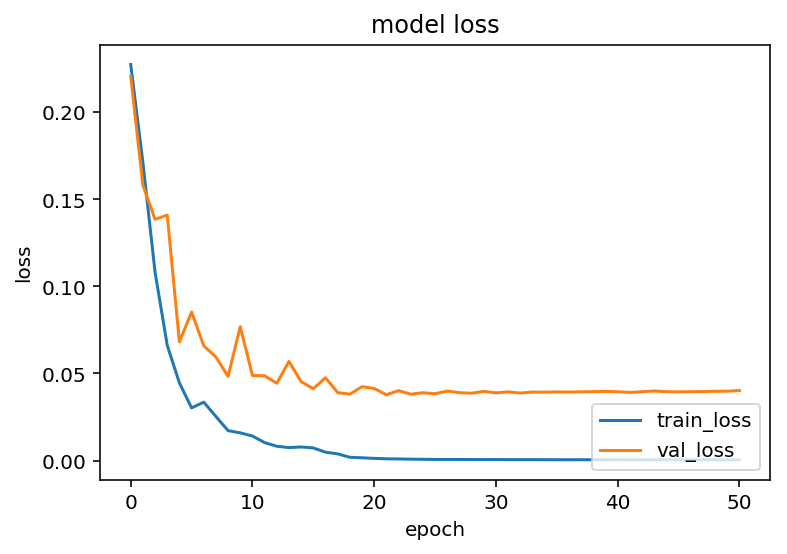

100%|██████████| 114/114 [00:11<00:00,  9.65it/s]
[2017-12-04 21:46:26,853 INFO] Epoch: 0 | TrainAcc: 0.1775 | TrainLoss: 0.2461
[2017-12-04 21:46:27,220 INFO] Epoch: 0 | ValAcc: 0.1540 | ValLoss: 0.2284 

[2017-12-04 21:46:28,502 INFO] Epoch: 1 | TrainAcc: 0.2565 | TrainLoss: 0.2191
[2017-12-04 21:46:28,855 INFO] Epoch: 1 | ValAcc: 0.2030 | ValLoss: 0.2080 

[2017-12-04 21:46:30,139 INFO] Epoch: 2 | TrainAcc: 0.3745 | TrainLoss: 0.1844
[2017-12-04 21:46:30,507 INFO] Epoch: 2 | ValAcc: 0.2890 | ValLoss: 0.1930 

[2017-12-04 21:46:31,802 INFO] Epoch: 3 | TrainAcc: 0.6255 | TrainLoss: 0.1209
[2017-12-04 21:46:32,154 INFO] Epoch: 3 | ValAcc: 0.5500 | ValLoss: 0.1247 

[2017-12-04 21:46:33,465 INFO] Epoch: 4 | TrainAcc: 0.7620 | TrainLoss: 0.0742
[2017-12-04 21:46:33,826 INFO] Epoch: 4 | ValAcc: 0.6590 | ValLoss: 0.1009 

[2017-12-04 21:46:35,121 INFO] Epoch: 5 | TrainAcc: 0.8045 | TrainLoss: 0.0576
[2017-12-04 21:46:35,483 INFO] Epoch: 5 | ValAcc: 0.6850 | ValLoss: 0.0949 

[2017-12-04 21

[2017-12-04 21:47:51,566 INFO] Epoch: 51 | ValAcc: 0.9060 | ValLoss: 0.0311 

[2017-12-04 21:47:52,859 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:47:53,217 INFO] Epoch: 52 | ValAcc: 0.9050 | ValLoss: 0.0314 

[2017-12-04 21:47:54,501 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:47:54,873 INFO] Epoch: 53 | ValAcc: 0.9050 | ValLoss: 0.0311 

[2017-12-04 21:47:56,171 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:47:56,528 INFO] Epoch: 54 | ValAcc: 0.9070 | ValLoss: 0.0313 

[2017-12-04 21:47:57,823 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:47:58,182 INFO] Epoch: 55 | ValAcc: 0.9040 | ValLoss: 0.0312 

[2017-12-04 21:47:59,461 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:47:59,821 INFO] Epoch: 56 | ValAcc: 0.9060 | ValLoss: 0.0312 

[2017-12-04 21:48:01,128 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:48:01,483 INFO] Epoch: 57 | ValAcc: 0

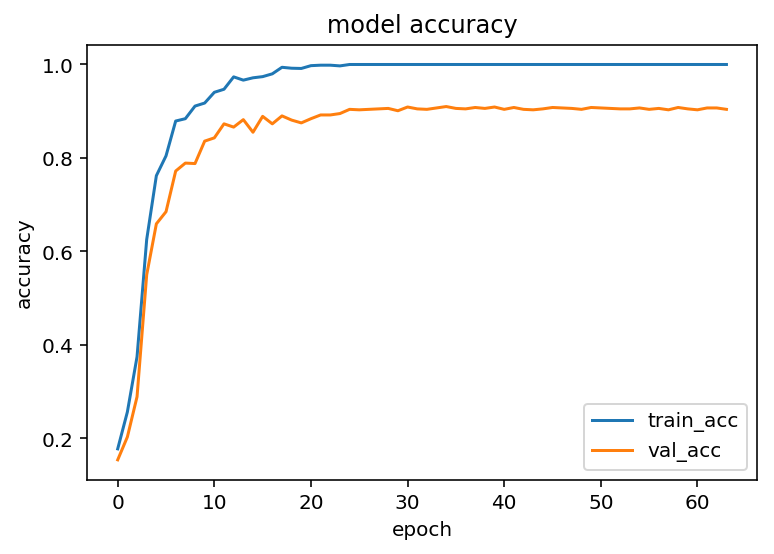

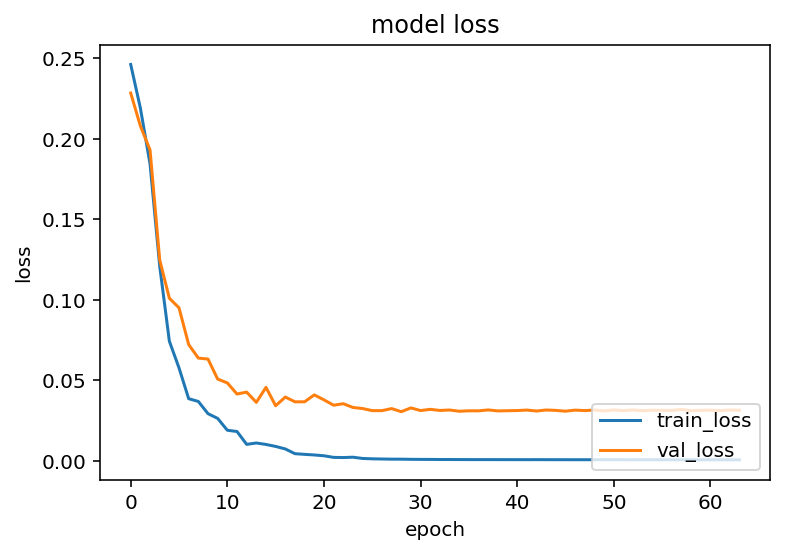

100%|██████████| 114/114 [00:11<00:00,  9.55it/s]
[2017-12-04 21:48:27,229 INFO] Epoch: 0 | TrainAcc: 0.1370 | TrainLoss: 0.2413
[2017-12-04 21:48:27,601 INFO] Epoch: 0 | ValAcc: 0.2040 | ValLoss: 0.2296 

[2017-12-04 21:48:28,917 INFO] Epoch: 1 | TrainAcc: 0.2520 | TrainLoss: 0.2120
[2017-12-04 21:48:29,275 INFO] Epoch: 1 | ValAcc: 0.2950 | ValLoss: 0.2075 

[2017-12-04 21:48:30,578 INFO] Epoch: 2 | TrainAcc: 0.4815 | TrainLoss: 0.1629
[2017-12-04 21:48:30,953 INFO] Epoch: 2 | ValAcc: 0.4600 | ValLoss: 0.1512 

[2017-12-04 21:48:32,247 INFO] Epoch: 3 | TrainAcc: 0.6240 | TrainLoss: 0.1082
[2017-12-04 21:48:32,602 INFO] Epoch: 3 | ValAcc: 0.5760 | ValLoss: 0.1112 

[2017-12-04 21:48:33,901 INFO] Epoch: 4 | TrainAcc: 0.7870 | TrainLoss: 0.0669
[2017-12-04 21:48:34,257 INFO] Epoch: 4 | ValAcc: 0.6110 | ValLoss: 0.1198 

[2017-12-04 21:48:35,557 INFO] Epoch: 5 | TrainAcc: 0.8525 | TrainLoss: 0.0455
[2017-12-04 21:48:35,936 INFO] Epoch: 5 | ValAcc: 0.7830 | ValLoss: 0.0631 

[2017-12-04 21

[2017-12-04 21:49:52,259 INFO] Epoch: 51 | ValAcc: 0.8830 | ValLoss: 0.0427 

[2017-12-04 21:49:53,537 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:49:53,893 INFO] Epoch: 52 | ValAcc: 0.8810 | ValLoss: 0.0425 

[2017-12-04 21:49:55,188 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:49:55,547 INFO] Epoch: 53 | ValAcc: 0.8820 | ValLoss: 0.0422 

[2017-12-04 21:49:56,837 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:49:57,199 INFO] Epoch: 54 | ValAcc: 0.8840 | ValLoss: 0.0426 

[2017-12-04 21:49:58,472 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:49:58,827 INFO] Epoch: 55 | ValAcc: 0.8800 | ValLoss: 0.0425 

[2017-12-04 21:50:00,103 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:50:00,458 INFO] Epoch: 56 | ValAcc: 0.8830 | ValLoss: 0.0427 

[2017-12-04 21:50:01,756 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-04 21:50:02,121 INFO] Epoch: 57 | ValAcc: 0

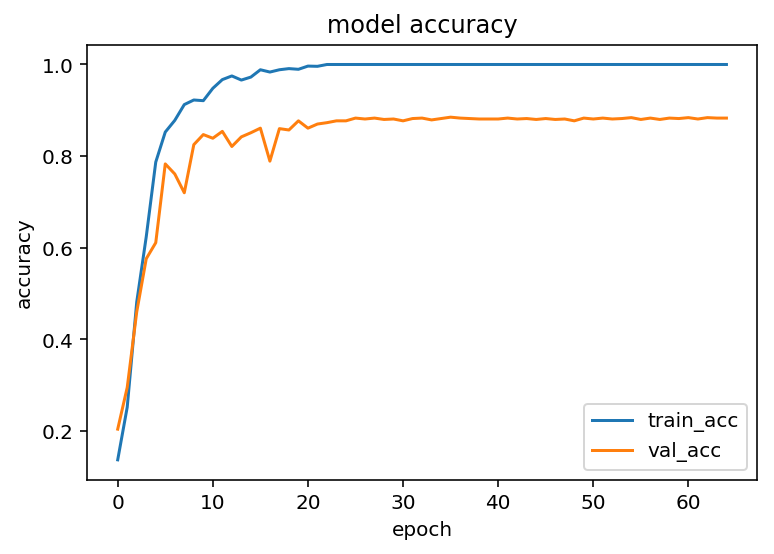

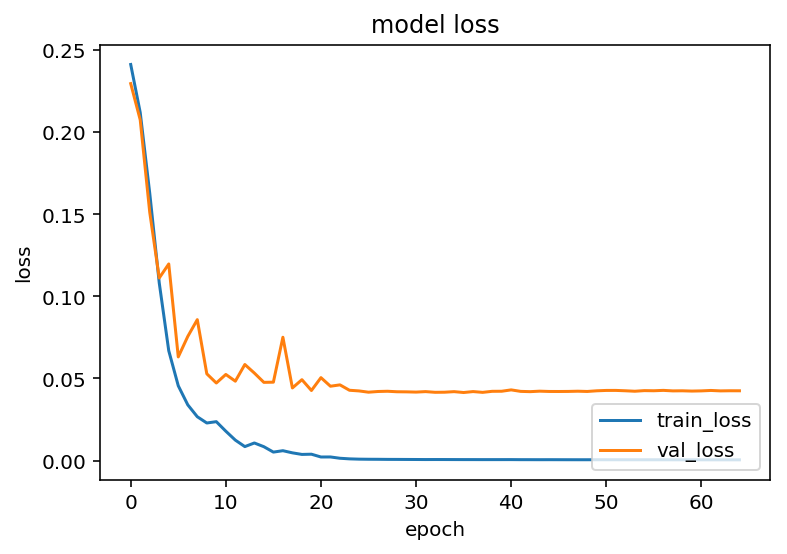

100%|██████████| 114/114 [00:11<00:00,  9.59it/s]
[2017-12-04 21:50:29,396 INFO] Epoch: 0 | TrainAcc: 0.1840 | TrainLoss: 0.2298
[2017-12-04 21:50:29,780 INFO] Epoch: 0 | ValAcc: 0.3520 | ValLoss: 0.2199 

[2017-12-04 21:50:31,091 INFO] Epoch: 1 | TrainAcc: 0.4185 | TrainLoss: 0.1811
[2017-12-04 21:50:31,453 INFO] Epoch: 1 | ValAcc: 0.4660 | ValLoss: 0.1596 

[2017-12-04 21:50:32,736 INFO] Epoch: 2 | TrainAcc: 0.6270 | TrainLoss: 0.1174
[2017-12-04 21:50:33,087 INFO] Epoch: 2 | ValAcc: 0.4430 | ValLoss: 0.1530 

[2017-12-04 21:50:34,369 INFO] Epoch: 3 | TrainAcc: 0.7575 | TrainLoss: 0.0739
[2017-12-04 21:50:34,724 INFO] Epoch: 3 | ValAcc: 0.7370 | ValLoss: 0.0825 

[2017-12-04 21:50:36,033 INFO] Epoch: 4 | TrainAcc: 0.8370 | TrainLoss: 0.0506
[2017-12-04 21:50:36,396 INFO] Epoch: 4 | ValAcc: 0.5810 | ValLoss: 0.1424 

[2017-12-04 21:50:37,683 INFO] Epoch: 5 | TrainAcc: 0.8570 | TrainLoss: 0.0434
[2017-12-04 21:50:38,039 INFO] Epoch: 5 | ValAcc: 0.7320 | ValLoss: 0.0882 

[2017-12-04 21

[2017-12-04 21:51:56,183 INFO] Epoch: 51 | ValAcc: 0.8940 | ValLoss: 0.0395 

[2017-12-04 21:51:57,921 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-04 21:51:58,364 INFO] Epoch: 52 | ValAcc: 0.8940 | ValLoss: 0.0396 

[2017-12-04 21:52:00,002 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-04 21:52:00,429 INFO] Epoch: 53 | ValAcc: 0.8910 | ValLoss: 0.0395 

[2017-12-04 21:52:01,968 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-04 21:52:02,371 INFO] Epoch: 54 | ValAcc: 0.8930 | ValLoss: 0.0393 

[2017-12-04 21:52:03,845 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-04 21:52:04,238 INFO] Epoch: 55 | ValAcc: 0.8980 | ValLoss: 0.0396 

[2017-12-04 21:52:05,681 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-04 21:52:06,085 INFO] Epoch: 56 | ValAcc: 0.8930 | ValLoss: 0.0396 

[2017-12-04 21:52:07,559 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-04 21:52:07,966 INFO] Epoch: 57 | ValAcc: 0

[2017-12-04 21:53:34,968 INFO] Epoch: 103 | ValAcc: 0.9020 | ValLoss: 0.0392 

[2017-12-04 21:53:36,436 INFO] Epoch: 104 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 21:53:36,839 INFO] Epoch: 104 | ValAcc: 0.9040 | ValLoss: 0.0391 

[2017-12-04 21:53:38,278 INFO] Epoch: 105 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 21:53:38,711 INFO] Epoch: 105 | ValAcc: 0.9040 | ValLoss: 0.0393 

[2017-12-04 21:53:40,148 INFO] Epoch: 106 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 21:53:40,543 INFO] Epoch: 106 | ValAcc: 0.9020 | ValLoss: 0.0390 

[2017-12-04 21:53:41,986 INFO] Epoch: 107 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 21:53:42,379 INFO] Epoch: 107 | ValAcc: 0.9040 | ValLoss: 0.0390 

[2017-12-04 21:53:43,829 INFO] Epoch: 108 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 21:53:44,227 INFO] Epoch: 108 | ValAcc: 0.9020 | ValLoss: 0.0391 

[2017-12-04 21:53:45,718 INFO] Epoch: 109 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 21:53:46,118 INFO] Epoch: 10

[2017-12-04 21:55:10,779 INFO] Epoch: 155 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 21:55:11,215 INFO] Epoch: 155 | ValAcc: 0.9020 | ValLoss: 0.0396 

[2017-12-04 21:55:12,663 INFO] Epoch: 156 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 21:55:13,054 INFO] Epoch: 156 | ValAcc: 0.9020 | ValLoss: 0.0396 

[2017-12-04 21:55:14,550 INFO] Epoch: 157 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 21:55:14,970 INFO] Epoch: 157 | ValAcc: 0.9030 | ValLoss: 0.0396 

[2017-12-04 21:55:16,420 INFO] Epoch: 158 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-04 21:55:16,843 INFO] Epoch: 158 | ValAcc: 0.9020 | ValLoss: 0.0394 

[2017-12-04 21:55:16,870 INFO] Accuracy dose not improve for a long epochs
[2017-12-04 21:55:16,872 INFO] Train done.
[2017-12-04 21:55:16,874 INFO] Elapsed Time: 288.6911301612854


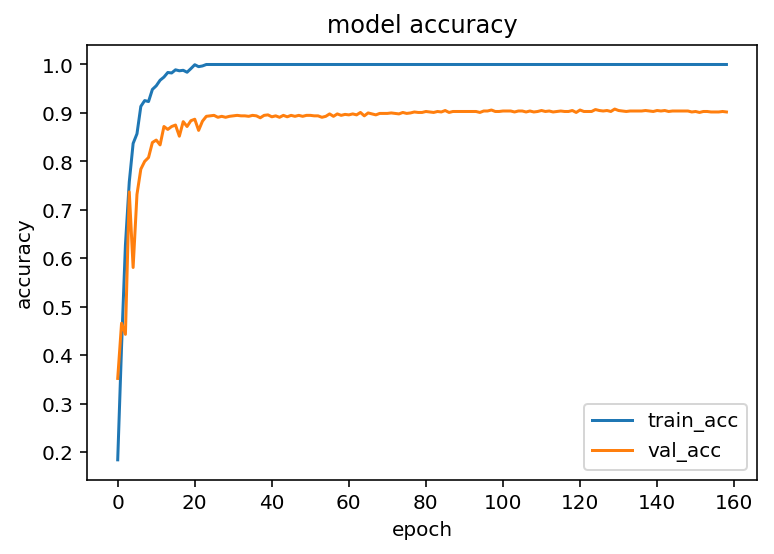

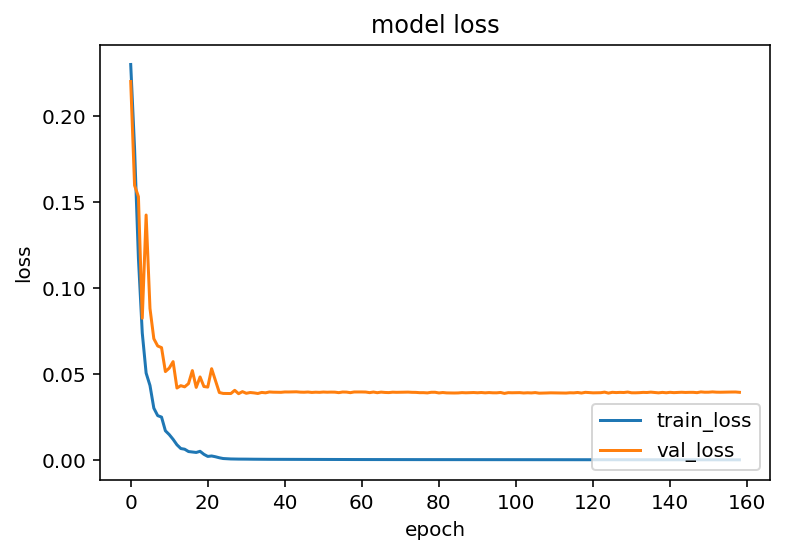

100%|██████████| 114/114 [00:13<00:00,  8.44it/s]
[2017-12-04 21:55:34,936 INFO] Epoch: 0 | TrainAcc: 0.1220 | TrainLoss: 0.2394
[2017-12-04 21:55:35,354 INFO] Epoch: 0 | ValAcc: 0.1980 | ValLoss: 0.2270 

[2017-12-04 21:55:36,782 INFO] Epoch: 1 | TrainAcc: 0.2045 | TrainLoss: 0.2148
[2017-12-04 21:55:37,181 INFO] Epoch: 1 | ValAcc: 0.2940 | ValLoss: 0.2067 

[2017-12-04 21:55:38,635 INFO] Epoch: 2 | TrainAcc: 0.4225 | TrainLoss: 0.1728
[2017-12-04 21:55:39,043 INFO] Epoch: 2 | ValAcc: 0.4220 | ValLoss: 0.1770 

[2017-12-04 21:55:40,686 INFO] Epoch: 3 | TrainAcc: 0.6615 | TrainLoss: 0.1098
[2017-12-04 21:55:41,081 INFO] Epoch: 3 | ValAcc: 0.5300 | ValLoss: 0.1429 

[2017-12-04 21:55:42,566 INFO] Epoch: 4 | TrainAcc: 0.7500 | TrainLoss: 0.0770
[2017-12-04 21:55:42,965 INFO] Epoch: 4 | ValAcc: 0.6900 | ValLoss: 0.0956 

[2017-12-04 21:55:44,398 INFO] Epoch: 5 | TrainAcc: 0.8105 | TrainLoss: 0.0559
[2017-12-04 21:55:44,803 INFO] Epoch: 5 | ValAcc: 0.6510 | ValLoss: 0.1217 

[2017-12-04 21

[2017-12-04 21:57:09,911 INFO] Epoch: 51 | ValAcc: 0.8890 | ValLoss: 0.0436 

[2017-12-04 21:57:11,350 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:57:11,743 INFO] Epoch: 52 | ValAcc: 0.8920 | ValLoss: 0.0431 

[2017-12-04 21:57:13,197 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:57:13,597 INFO] Epoch: 53 | ValAcc: 0.8870 | ValLoss: 0.0440 

[2017-12-04 21:57:15,034 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:57:15,435 INFO] Epoch: 54 | ValAcc: 0.8920 | ValLoss: 0.0433 

[2017-12-04 21:57:16,878 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:57:17,273 INFO] Epoch: 55 | ValAcc: 0.8910 | ValLoss: 0.0434 

[2017-12-04 21:57:18,715 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:57:19,117 INFO] Epoch: 56 | ValAcc: 0.8920 | ValLoss: 0.0435 

[2017-12-04 21:57:20,612 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 21:57:21,047 INFO] Epoch: 57 | ValAcc: 0

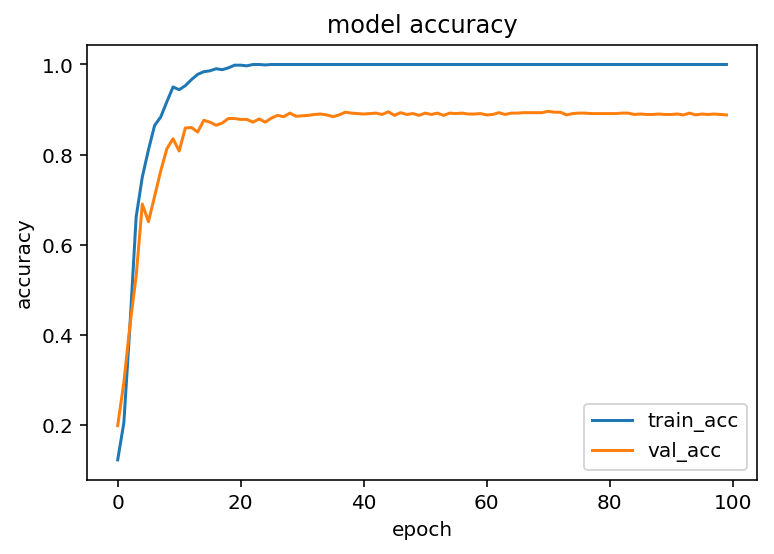

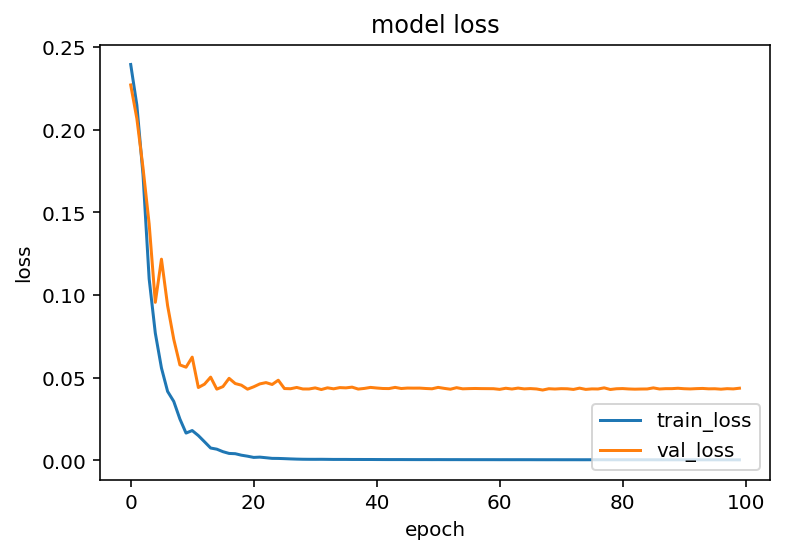

100%|██████████| 114/114 [00:13<00:00,  8.37it/s]
[2017-12-04 21:58:57,006 INFO] Epoch: 0 | TrainAcc: 0.2270 | TrainLoss: 0.2194
[2017-12-04 21:58:57,413 INFO] Epoch: 0 | ValAcc: 0.1550 | ValLoss: 0.2201 

[2017-12-04 21:58:58,875 INFO] Epoch: 1 | TrainAcc: 0.3610 | TrainLoss: 0.1771
[2017-12-04 21:58:59,270 INFO] Epoch: 1 | ValAcc: 0.4830 | ValLoss: 0.1610 

[2017-12-04 21:59:00,699 INFO] Epoch: 2 | TrainAcc: 0.6415 | TrainLoss: 0.1108
[2017-12-04 21:59:01,112 INFO] Epoch: 2 | ValAcc: 0.6360 | ValLoss: 0.1092 

[2017-12-04 21:59:02,568 INFO] Epoch: 3 | TrainAcc: 0.8410 | TrainLoss: 0.0558
[2017-12-04 21:59:02,976 INFO] Epoch: 3 | ValAcc: 0.6890 | ValLoss: 0.0935 

[2017-12-04 21:59:04,460 INFO] Epoch: 4 | TrainAcc: 0.8955 | TrainLoss: 0.0371
[2017-12-04 21:59:04,863 INFO] Epoch: 4 | ValAcc: 0.7210 | ValLoss: 0.0998 

[2017-12-04 21:59:06,297 INFO] Epoch: 5 | TrainAcc: 0.9280 | TrainLoss: 0.0275
[2017-12-04 21:59:06,696 INFO] Epoch: 5 | ValAcc: 0.8550 | ValLoss: 0.0457 

[2017-12-04 21

[2017-12-04 22:00:32,752 INFO] Epoch: 51 | ValAcc: 0.9070 | ValLoss: 0.0345 

[2017-12-04 22:00:34,204 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-04 22:00:34,602 INFO] Epoch: 52 | ValAcc: 0.9090 | ValLoss: 0.0346 

[2017-12-04 22:00:36,050 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-04 22:00:36,445 INFO] Epoch: 53 | ValAcc: 0.9100 | ValLoss: 0.0352 

[2017-12-04 22:00:37,906 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-04 22:00:38,309 INFO] Epoch: 54 | ValAcc: 0.9060 | ValLoss: 0.0345 

[2017-12-04 22:00:39,752 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-04 22:00:40,291 INFO] Epoch: 55 | ValAcc: 0.9060 | ValLoss: 0.0348 

[2017-12-04 22:00:41,819 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-04 22:00:42,222 INFO] Epoch: 56 | ValAcc: 0.9070 | ValLoss: 0.0347 

[2017-12-04 22:00:43,694 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-04 22:00:44,111 INFO] Epoch: 57 | ValAcc: 0

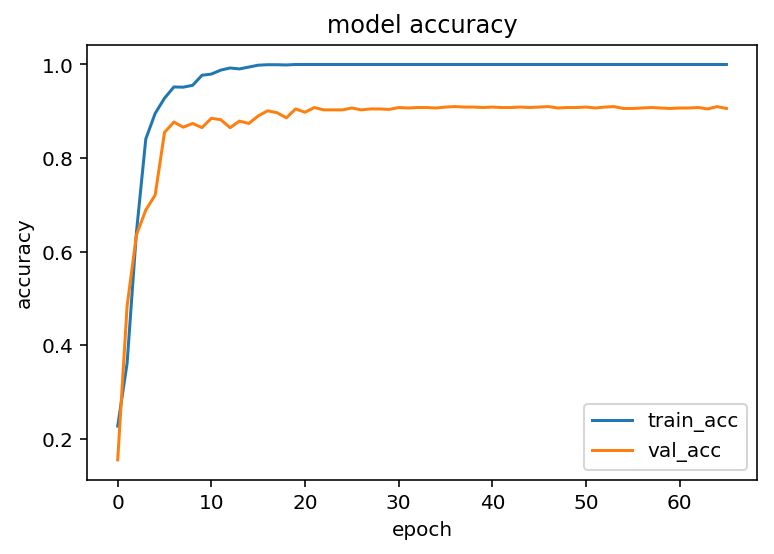

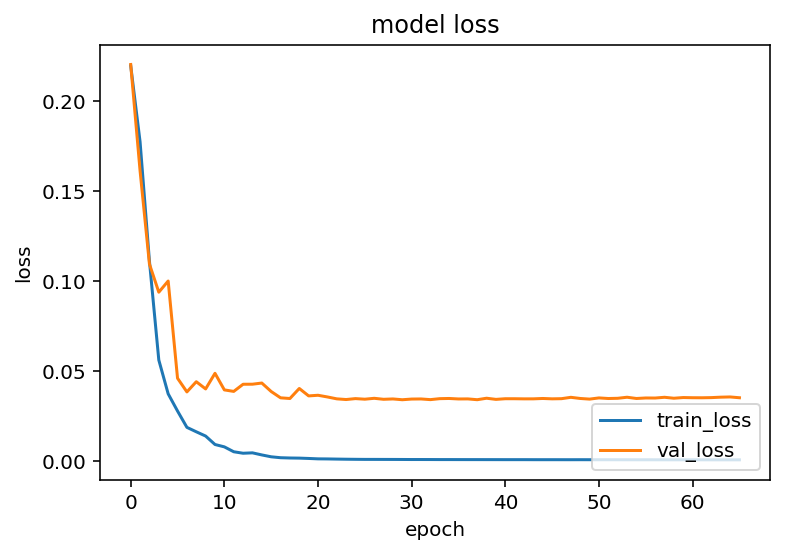

100%|██████████| 114/114 [00:13<00:00,  8.41it/s]
[2017-12-04 22:01:16,966 INFO] Epoch: 0 | TrainAcc: 0.1920 | TrainLoss: 0.2317
[2017-12-04 22:01:17,378 INFO] Epoch: 0 | ValAcc: 0.1610 | ValLoss: 0.2197 

[2017-12-04 22:01:18,848 INFO] Epoch: 1 | TrainAcc: 0.4405 | TrainLoss: 0.1700
[2017-12-04 22:01:19,256 INFO] Epoch: 1 | ValAcc: 0.4100 | ValLoss: 0.1622 

[2017-12-04 22:01:20,799 INFO] Epoch: 2 | TrainAcc: 0.6465 | TrainLoss: 0.1047
[2017-12-04 22:01:21,213 INFO] Epoch: 2 | ValAcc: 0.6400 | ValLoss: 0.1030 

[2017-12-04 22:01:22,648 INFO] Epoch: 3 | TrainAcc: 0.8275 | TrainLoss: 0.0525
[2017-12-04 22:01:23,055 INFO] Epoch: 3 | ValAcc: 0.6620 | ValLoss: 0.0975 

[2017-12-04 22:01:24,507 INFO] Epoch: 4 | TrainAcc: 0.8940 | TrainLoss: 0.0356
[2017-12-04 22:01:24,899 INFO] Epoch: 4 | ValAcc: 0.7560 | ValLoss: 0.0749 

[2017-12-04 22:01:26,371 INFO] Epoch: 5 | TrainAcc: 0.9200 | TrainLoss: 0.0268
[2017-12-04 22:01:26,778 INFO] Epoch: 5 | ValAcc: 0.8220 | ValLoss: 0.0563 

[2017-12-04 22

[2017-12-04 22:02:52,468 INFO] Epoch: 51 | ValAcc: 0.8890 | ValLoss: 0.0377 

[2017-12-04 22:02:53,911 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-04 22:02:54,313 INFO] Epoch: 52 | ValAcc: 0.8880 | ValLoss: 0.0377 

[2017-12-04 22:02:55,749 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-04 22:02:56,177 INFO] Epoch: 53 | ValAcc: 0.8890 | ValLoss: 0.0380 

[2017-12-04 22:02:57,648 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-04 22:02:58,051 INFO] Epoch: 54 | ValAcc: 0.8890 | ValLoss: 0.0375 

[2017-12-04 22:02:59,535 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-04 22:02:59,946 INFO] Epoch: 55 | ValAcc: 0.8900 | ValLoss: 0.0384 

[2017-12-04 22:03:01,426 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-04 22:03:01,821 INFO] Epoch: 56 | ValAcc: 0.8930 | ValLoss: 0.0377 

[2017-12-04 22:03:03,279 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-04 22:03:03,686 INFO] Epoch: 57 | ValAcc: 0

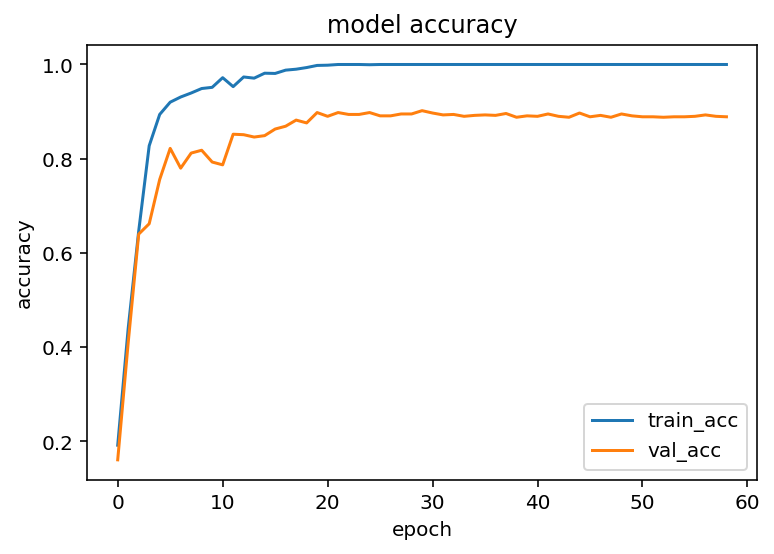

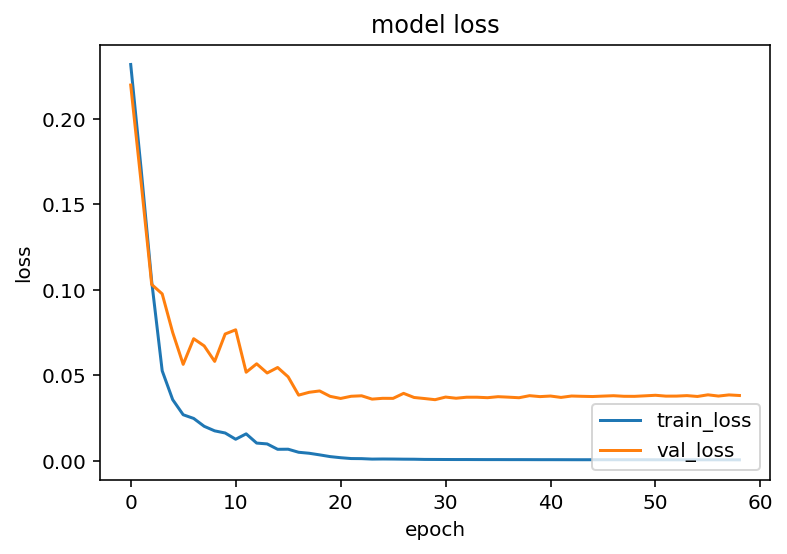

100%|██████████| 114/114 [00:13<00:00,  8.25it/s]
[2017-12-04 22:03:23,782 INFO] Epoch: 0 | TrainAcc: 0.1890 | TrainLoss: 0.2445
[2017-12-04 22:03:24,197 INFO] Epoch: 0 | ValAcc: 0.2130 | ValLoss: 0.2231 

[2017-12-04 22:03:25,654 INFO] Epoch: 1 | TrainAcc: 0.3285 | TrainLoss: 0.1967
[2017-12-04 22:03:26,090 INFO] Epoch: 1 | ValAcc: 0.4490 | ValLoss: 0.1849 

[2017-12-04 22:03:27,539 INFO] Epoch: 2 | TrainAcc: 0.5145 | TrainLoss: 0.1464
[2017-12-04 22:03:27,934 INFO] Epoch: 2 | ValAcc: 0.5710 | ValLoss: 0.1357 

[2017-12-04 22:03:29,417 INFO] Epoch: 3 | TrainAcc: 0.7435 | TrainLoss: 0.0821
[2017-12-04 22:03:29,837 INFO] Epoch: 3 | ValAcc: 0.7280 | ValLoss: 0.0845 

[2017-12-04 22:03:31,299 INFO] Epoch: 4 | TrainAcc: 0.8620 | TrainLoss: 0.0437
[2017-12-04 22:03:31,702 INFO] Epoch: 4 | ValAcc: 0.7840 | ValLoss: 0.0671 

[2017-12-04 22:03:33,135 INFO] Epoch: 5 | TrainAcc: 0.8995 | TrainLoss: 0.0319
[2017-12-04 22:03:33,526 INFO] Epoch: 5 | ValAcc: 0.7490 | ValLoss: 0.0887 

[2017-12-04 22

[2017-12-04 22:04:58,946 INFO] Epoch: 51 | ValAcc: 0.9140 | ValLoss: 0.0361 

[2017-12-04 22:05:00,396 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 22:05:00,803 INFO] Epoch: 52 | ValAcc: 0.9120 | ValLoss: 0.0357 

[2017-12-04 22:05:02,287 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 22:05:02,694 INFO] Epoch: 53 | ValAcc: 0.9100 | ValLoss: 0.0362 

[2017-12-04 22:05:04,198 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 22:05:04,599 INFO] Epoch: 54 | ValAcc: 0.9120 | ValLoss: 0.0359 

[2017-12-04 22:05:06,064 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 22:05:06,456 INFO] Epoch: 55 | ValAcc: 0.9110 | ValLoss: 0.0363 

[2017-12-04 22:05:07,894 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 22:05:08,302 INFO] Epoch: 56 | ValAcc: 0.9080 | ValLoss: 0.0363 

[2017-12-04 22:05:09,761 INFO] Epoch: 57 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-04 22:05:10,183 INFO] Epoch: 57 | ValAcc: 0

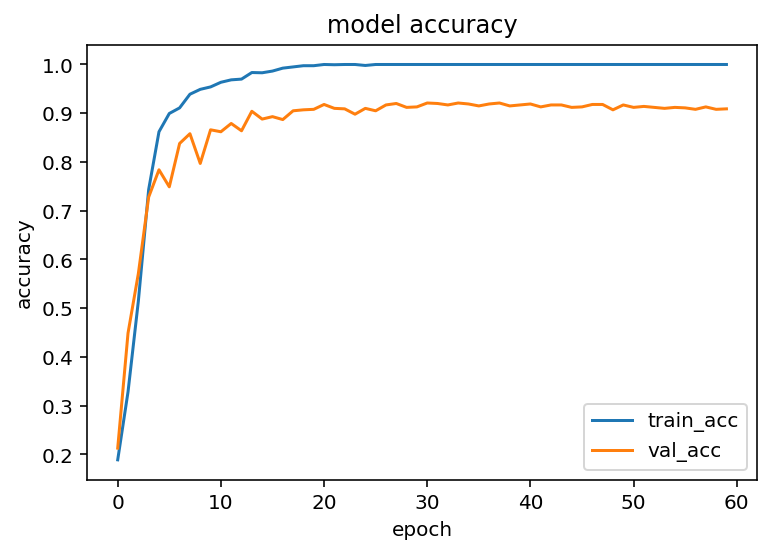

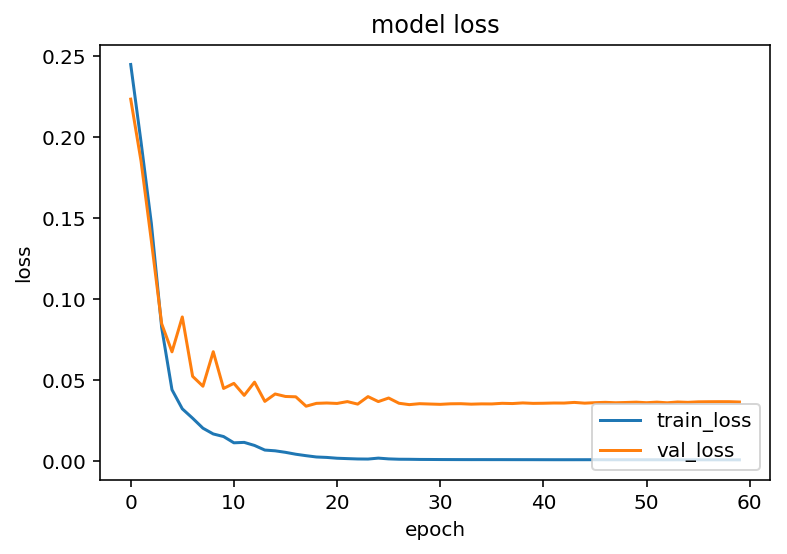

100%|██████████| 114/114 [00:13<00:00,  8.21it/s]


In [44]:
# set experimental params
epochs = 1000
lr = 0.5
momentum = 0.9
ratio_pl = 1.0 # ratio of train:pseudo
hard = False
ex_name = 'accurate_pseudo_soft'
trial_times = 10

logzero.logfile('./log/{}.log'.format(ex_name))

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

results_soft = {}
results_soft['test_acc'] = np.empty((trial_times))
results_soft['test_loss'] = np.empty((trial_times))
results_soft['unlabeled_acc'] = np.empty((trial_times))
results_soft['unlabeled_loss'] = np.empty((trial_times))
for i in range(trial_times):
    train_dataset = MNISTDatasetForPseudoLabeling(
        X_train, y_train, X_pseudo, y_pseudo, ratio_pl, hard, transform)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_dataset = MNISTDataset(X_val, y_val, transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=test_batch_size, num_workers=num_workers)
    test_dataset = MNISTDataset(X_test, y_test, transform)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, num_workers=num_workers)
    unlabeled_dataset = MNISTDataset(X_unlabeled, y_unlabeled, transform)
    unlabeled_loader = torch.utils.data.DataLoader(
        unlabeled_dataset, batch_size=test_batch_size, num_workers=num_workers)

    model = Net()
    if use_gpu:
        model.cuda()

    def save_checkpoint(state, filename='./save/checkpoint_{}.pth'.format(ex_name)):
        torch.save(state, filename)

    criterion = nn.KLDivLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    tracker = TrainingTracker()

    start = time.time()

    for epoch in range(0, epochs):
        tracker.epoch = epoch

        _train(model, train_loader, criterion, optimizer, tracker)
        _validate(model, val_loader, criterion, tracker)

        # if latest accuracy is the best in history
        if len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) == 1:
            save_checkpoint({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            })
        elif len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) >= 30:
            logger.info('Accuracy dose not improve for a long epochs')
            break

    logger.info('Train done.')
    logger.info('Elapsed Time: {}'.format(time.time() - start))
    tracker.plot_history()
    
    model = Net()
    resume = torch.load('./save/checkpoint_{}.pth'.format(ex_name))
    model.load_state_dict(resume['state_dict'])
    results_soft['test_acc'][i], results_soft['test_loss'][i] = \
        _test(model, test_loader, criterion)
    results_soft['unlabeled_acc'][i], results_soft['unlabeled_loss'][i] = \
        _test(model, unlabeled_loader, criterion)

In [45]:
logger.info('Test Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results_soft['test_acc']),
    np.std(results_soft['test_acc'])
))
logger.info('Test Loss: {:.4f} ± {:.4f}\n'.format(
    np.mean(results_soft['test_loss']),
    np.std(results_soft['test_loss'])
))

logger.info('Unlabeled Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results_soft['unlabeled_acc']),
    np.std(results_soft['unlabeled_acc'])
))
logger.info('Unlabeled Loss: {:.4f} ± {:.4f}'.format(
    np.mean(results_soft['unlabeled_loss']),
    np.std(results_soft['unlabeled_loss'])
))

[2017-12-04 22:05:30,949 INFO] Test Accuracy: 0.9103 ± 0.0071
[2017-12-04 22:05:30,951 INFO] Test Loss: 0.0329 ± 0.0032

[2017-12-04 22:05:30,954 INFO] Unlabeled Accuracy: 0.9030 ± 0.0070
[2017-12-04 22:05:30,955 INFO] Unlabeled Loss: 0.0358 ± 0.0036


In [46]:
from scipy import stats

t, p = stats.ttest_rel(results['test_acc'], results_soft['test_acc'])
print( "p値 = %(p)s" %locals() )

p値 = 0.813157736175
